# High-fidelity prototype

# Analysis of ORCHID Dataset: https://physionet.org/content/orchid/1.0.0/

# Part 1: Research Question 1 (Prediction of organ donor selection)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import warnings
import io
from google.colab import files

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.inspection import permutation_importance

from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import RocCurveDisplay, auc, roc_curve
from sklearn import metrics

from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

from imblearn.over_sampling import SMOTE

from sklearn.compose import ColumnTransformer

from datetime import datetime
import time

warnings.filterwarnings('ignore')

In [ ]:
# Choose the dataset to upload
uploaded = files.upload()

Saving opd.csv to opd.csv


In [ ]:
# Read the dataset into a Pandas DataFrame
df = pd.read_csv(io.BytesIO(uploaded['opd.csv']))
# Inspect the first five rows of the data
df.head()

OPO     PatientID   Age Gender                      Race   HospitalID  \
0  OPO1  OPO1_P320866  62.0      M         White / Caucasian  OPO1_H23456   
1  OPO1  OPO1_P549364  14.0      F         White / Caucasian  OPO1_H11908   
2  OPO1  OPO1_P536997  55.0      M         White / Caucasian  OPO1_H23111   
3  OPO1  OPO1_P463285  48.0      F  Black / African American  OPO1_H26589   
4  OPO1  OPO1_P284978  80.0      F         White / Caucasian   OPO1_H5832   

   brain_death Cause_of_Death_OPO Cause_of_Death_UNOS Mechanism_of_Death  ...  \
0        False                NaN         Head Trauma                NaN  ...   
1        False                NaN                 NaN                NaN  ...   
2        False                NaN          CVA/Stroke         ICH/Stroke  ...   
3        False                NaN              Anoxia     Cardiovascular  ...   
4        False                NaN                 NaN                NaN  ...   

  Referral_Year  Procured_Year  outcome_heart  outcome_liver  \
0          2018            NaN            NaN            NaN   
1          2021            NaN            NaN            NaN   
2          2015            NaN            NaN            NaN   
3          2019            NaN            NaN            NaN   
4          2018            NaN            NaN            NaN   

   outcome_kidney_left  outcome_kidney_right  outcome_lung_left  \
0                  NaN                   NaN                NaN   
1                  NaN                   NaN                NaN   
2                  NaN                   NaN                NaN   
3                  NaN                   NaN                NaN   
4                  NaN                   NaN                NaN   

  outcome_lung_right outcome_intestine outcome_pancreas  
0                NaN               NaN              NaN  
1                NaN               NaN              NaN  
2                NaN               NaN              NaN  
3                NaN               NaN              NaN  
4                NaN               NaN              NaN  

[5 rows x 34 columns]

Try this if above is already uploaded

In [ ]:
df = pd.read_csv('opd.csv')

In [ ]:
# Remove Patient and Hospital ID columns since they are not actual features
df = df.drop(['PatientID','HospitalID'], axis=1)
df.head()

OPO   Age Gender                      Race  brain_death  \
0  OPO1  62.0      M         White / Caucasian        False   
1  OPO1  14.0      F         White / Caucasian        False   
2  OPO1  55.0      M         White / Caucasian        False   
3  OPO1  48.0      F  Black / African American        False   
4  OPO1  80.0      F         White / Caucasian        False   

  Cause_of_Death_OPO Cause_of_Death_UNOS Mechanism_of_Death  \
0                NaN         Head Trauma                NaN   
1                NaN                 NaN                NaN   
2                NaN          CVA/Stroke         ICH/Stroke   
3                NaN              Anoxia     Cardiovascular   
4                NaN                 NaN                NaN   

  Circumstances_of_Death  approached  ...  Referral_Year  Procured_Year  \
0                    NaN       False  ...           2018            NaN   
1                    NaN       False  ...           2021            NaN   
2      None of the Above        True  ...           2015            NaN   
3      None of the Above       False  ...           2019            NaN   
4                    NaN       False  ...           2018            NaN   

   outcome_heart  outcome_liver  outcome_kidney_left outcome_kidney_right  \
0            NaN            NaN                  NaN                  NaN   
1            NaN            NaN                  NaN                  NaN   
2            NaN            NaN                  NaN                  NaN   
3            NaN            NaN                  NaN                  NaN   
4            NaN            NaN                  NaN                  NaN   

  outcome_lung_left outcome_lung_right outcome_intestine outcome_pancreas  
0               NaN                NaN               NaN              NaN  
1               NaN                NaN               NaN              NaN  
2               NaN                NaN               NaN              NaN  
3               NaN                NaN               NaN              NaN  
4               NaN                NaN               NaN              NaN  

[5 rows x 32 columns]

# Exploratory data analysis

In [ ]:
# Description of continuous variables
# The Year variables need to be changed to categorical in feature engineering stage
df.describe(include='all')

OPO            Age  Gender               Race brain_death  \
count   133101  133017.000000  133040             133101      133101   
unique       6            NaN       2                  4           2   
top       OPO4            NaN       M  White / Caucasian       False   
freq     33641            NaN   78271              79688      121170   
mean       NaN      57.659795     NaN                NaN         NaN   
std        NaN      18.319720     NaN                NaN         NaN   
min        NaN       0.000000     NaN                NaN         NaN   
25%        NaN      48.000000     NaN                NaN         NaN   
50%        NaN      61.000000     NaN                NaN         NaN   
75%        NaN      71.000000     NaN                NaN         NaN   
max        NaN     100.000000     NaN                NaN         NaN   

              Cause_of_Death_OPO Cause_of_Death_UNOS Mechanism_of_Death  \
count                      32395              103282              98532   
unique                        80                  37                 19   
top     Cardiac - Other, specify              Anoxia     Cardiovascular   
freq                        6511               40366              27266   
mean                         NaN                 NaN                NaN   
std                          NaN                 NaN                NaN   
min                          NaN                 NaN                NaN   
25%                          NaN                 NaN                NaN   
50%                          NaN                 NaN                NaN   
75%                          NaN                 NaN                NaN   
max                          NaN                 NaN                NaN   

       Circumstances_of_Death approached  ...  Referral_Year Procured_Year  \
count                   98587     133101  ...  133101.000000   9543.000000   
unique                     14          2  ...            NaN           NaN   
top            Natural Causes      False  ...            NaN           NaN   
freq                    60699     113550  ...            NaN           NaN   
mean                      NaN        NaN  ...    2018.563001   2018.372105   
std                       NaN        NaN  ...       1.957253      2.012788   
min                       NaN        NaN  ...    2015.000000   1987.000000   
25%                       NaN        NaN  ...    2017.000000   2017.000000   
50%                       NaN        NaN  ...    2019.000000   2019.000000   
75%                       NaN        NaN  ...    2020.000000   2020.000000   
max                       NaN        NaN  ...    2021.000000   2022.000000   

       outcome_heart outcome_liver outcome_kidney_left outcome_kidney_right  \
count           3690          7902                8802                 8811   
unique             3             3                   4                    3   
top     Transplanted  Transplanted        Transplanted         Transplanted   
freq            2987          7014                7083                 7052   
mean             NaN           NaN                 NaN                  NaN   
std              NaN           NaN                 NaN                  NaN   
min              NaN           NaN                 NaN                  NaN   
25%              NaN           NaN                 NaN                  NaN   
50%              NaN           NaN                 NaN                  NaN   
75%              NaN           NaN                 NaN                  NaN   
max              NaN           NaN                 NaN                  NaN   

       outcome_lung_left outcome_lung_right       outcome_intestine  \
count               3407               3447                     368   
unique                 4                  4                       3   
top         Transplanted       Transplanted  Recovered for Research   
freq                2145               2126                     279   
mean

# Missing values

In [ ]:
def get_missing_data(data):
  """
  Returns DataFrame with percent missing data from input data (DataFrame).

  Parameters
  -----
  data (DataFrame): input dataframe

  Returns
  -----
  missing_data (DataFrame): output dataframe with % missing values
  """

  #print(data.isnull().sum()) # uncomment this if you want to see list of counts

  # Get percentage of missing values in each column
  missing_data_prop={}
  for x,y in enumerate(list(data.isnull().sum())):
    missing_data_prop[data.columns[x]]=(float(y/data.shape[0])*100) #"{:.2f}".format

  missing_data=pd.DataFrame(missing_data_prop.items(), columns=['column', 'percent_missing'])
  return missing_data

missing_data=get_missing_data(df)
missing_data

column  percent_missing
0                      OPO         0.000000
1                      Age         0.063110
2                   Gender         0.045830
3                     Race         0.000000
4              brain_death         0.000000
5       Cause_of_Death_OPO        75.661340
6      Cause_of_Death_UNOS        22.403288
7       Mechanism_of_Death        25.972006
8   Circumstances_of_Death        25.930684
9               approached         0.000000
10              authorized         0.000000
11                procured         0.000000
12            transplanted         0.000000
13         Tissue_Referral         0.000000
14            Eye_Referral         0.000000
15           time_asystole        32.798401
16        time_brain_death        91.092479
17           time_referred         0.000000
18         time_approached        83.360756
19         time_authorized        85.060969
20           time_procured        92.830257
21      Referral_DayofWeek         0.000000
22           Referral_Year         0.000000
23           Procured_Year        92.830257
24           outcome_heart        97.227669
25           outcome_liver        94.063155
26     outcome_kidney_left        93.386977
27    outcome_kidney_right        93.380215
28       outcome_lung_left        97.440290
29      outcome_lung_right        97.410237
30       outcome_intestine        99.723518
31        outcome_pancreas        98.738552

# Run this to get list of columns to drop for later

In [ ]:
cols_large_missing=list(missing_data[missing_data['percent_missing']>50]['column'])
print(f'{len(cols_large_missing)} columns to drop due to over 50% missing')
cols_large_missing #over 50% missing
# Note: outcome_organ variables are not randomly missing - only donors selected for
# transplant had these columns filled in

14 columns to drop due to over 50% missing


['Cause_of_Death_OPO',
 'time_brain_death',
 'time_approached',
 'time_authorized',
 'time_procured',
 'Procured_Year',
 'outcome_heart',
 'outcome_liver',
 'outcome_kidney_left',
 'outcome_kidney_right',
 'outcome_lung_left',
 'outcome_lung_right',
 'outcome_intestine',
 'outcome_pancreas']

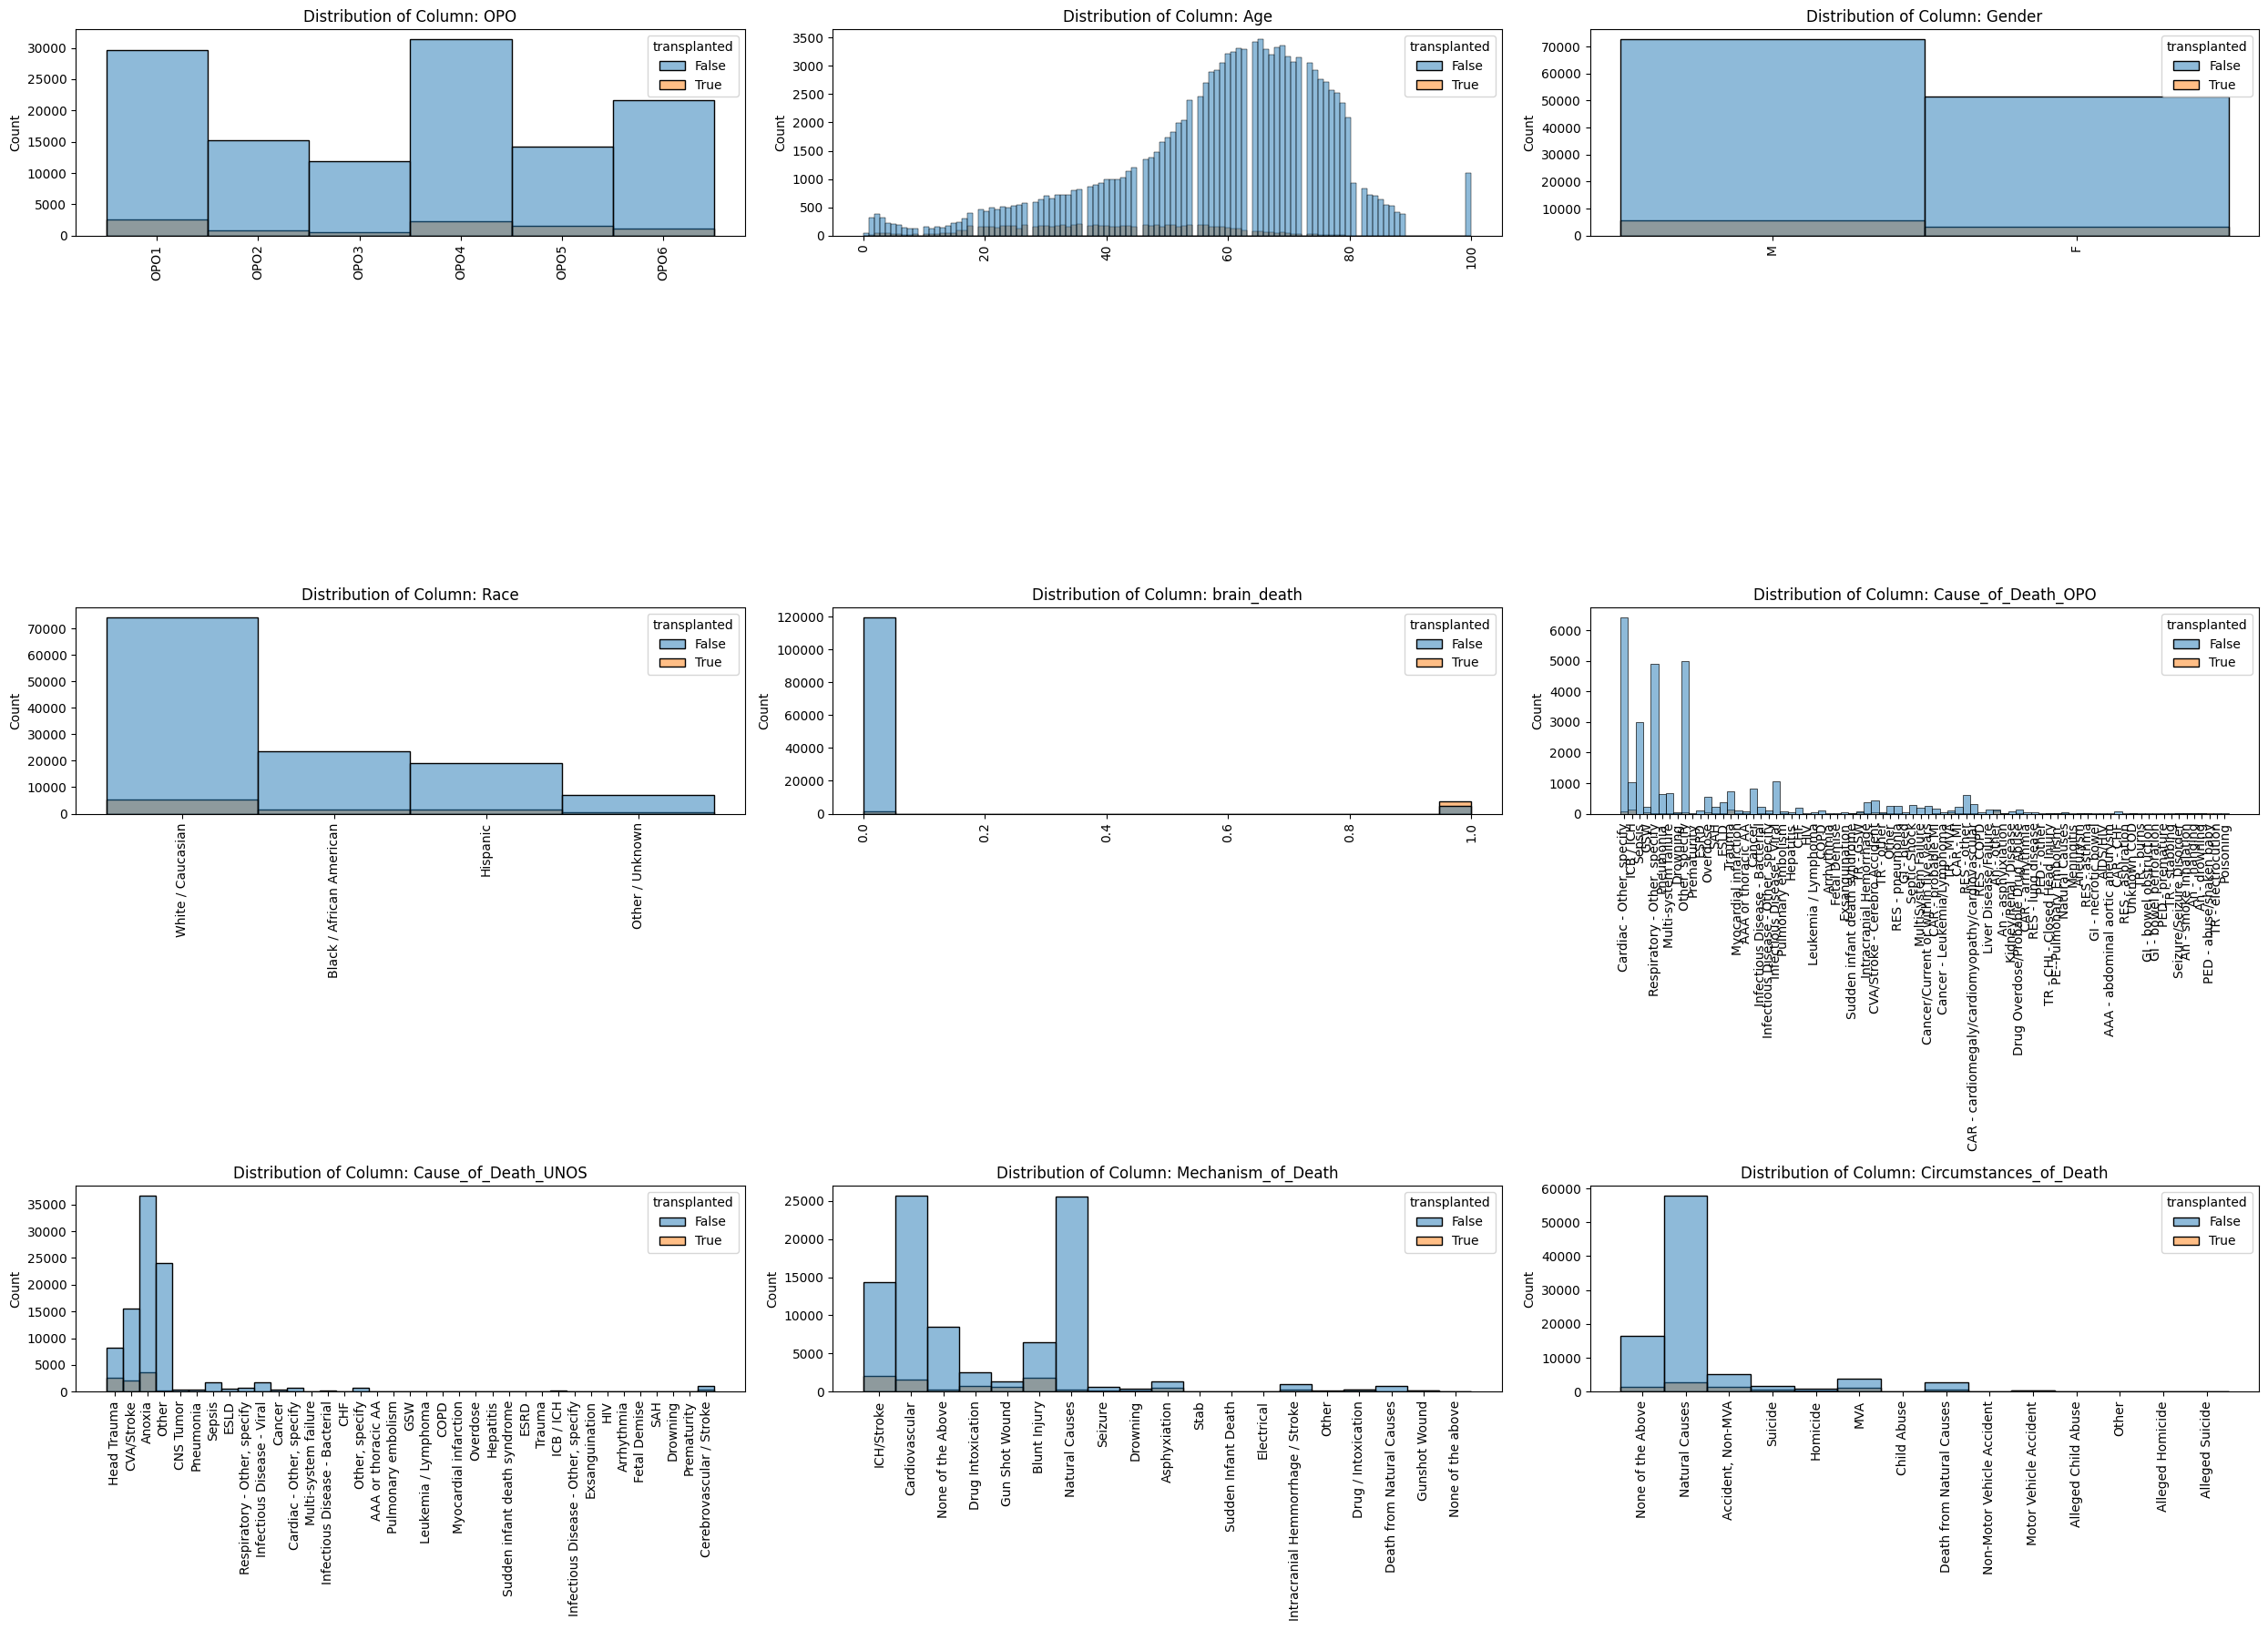

In [ ]:
#Batch process as running this loop on entire dataset causes system to crash

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(25, 18), sharex=False, sharey=False)
axes = axes.ravel()
cols = df.columns[:9]

for col, ax in zip(cols, axes):
    sns.histplot(data=df, x=col, hue='transplanted', fill=True, ax=ax)
    ax.tick_params(axis='x', rotation=90)
    ax.set(title=f'Distribution of Column: {col}', xlabel=None)

#fig.delaxes(axes[5])  # delete the empty subplot
fig.tight_layout()
plt.show()

In [ ]:
# Display unique values for OPO and UNOS definitions
 #ESLD=end-stage liver failure, CHF=congestive heart failure, GSW=gunshot wound, ESRD=end stage renal (kidney) disease, SAH=Subarachnoid hemorrhage (SAH)
print(df['Cause_of_Death_OPO'].unique())
print(df['Cause_of_Death_UNOS'].unique())
print(df['Mechanism_of_Death'].unique())
print(df['Circumstances_of_Death'].unique())

[nan 'Cardiac - Other, specify' 'ICB / ICH' 'Sepsis' 'GSW'
 'Respiratory - Other, specify' 'Pneumonia' 'Multi-system failure'
 'Drowning' 'Other, specify' 'Prematurity' 'ESRD' 'Overdose' 'SAH' 'ESLD'
 'Trauma' 'Myocardial infarction' 'AAA or thoracic AA' 'Cancer'
 'Infectious Disease - Bacterial' 'Infectious Disease - Other, specify'
 'Infectious Disease - Viral' 'Pulmonary embolism' 'Hepatitis' 'CHF' 'HIV'
 'Leukemia / Lymphoma' 'COPD' 'Arrhythmia' 'Fetal Demise' 'Exsanguination'
 'Sudden infant death syndrome' 'TR - GSW' 'Intracranial Hemorrhage'
 'CVA/Stroke - Cerebro Accident' 'TR - other' 'Other' 'RES - pneumonia'
 'GI - bleed' 'Septic Shock' 'MultiSystem Failure'
 'Cancer/Current or within five years' 'CAR - probable MI'
 'Cancer - Leukemia/Lymphoma' 'TR - MVA' 'CAR - MI' 'RES - other'
 'CAR - cardiomegaly/cardiomyopathy/cardiovascular' 'RES - COPD'
 'Liver Disease/Failure' 'An - other' 'An - asphyixiation'
 'Kidney/Renal  Disease' 'Drug Overdose/Probable Drug Abuse'
 'CAR - arrh

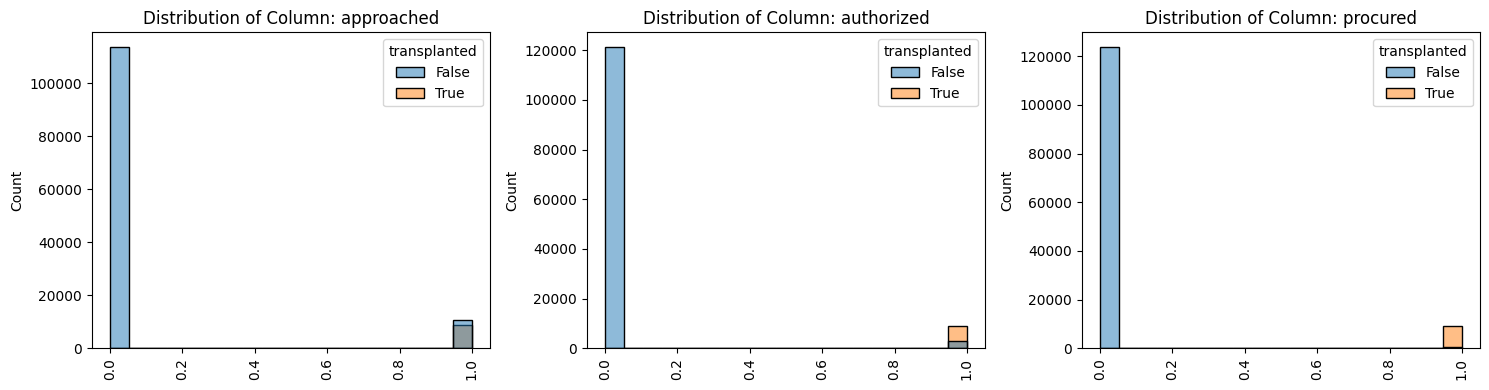

In [ ]:
#Batch process as running this loop on entire dataset causes system to crash

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), sharex=False, sharey=False)
axes = axes.ravel()
cols = df.columns[9:12]

for col, ax in zip(cols, axes):
    sns.histplot(data=df, x=col, hue='transplanted', fill=True, ax=ax)
    ax.tick_params(axis='x', rotation=90)
    ax.set(title=f'Distribution of Column: {col}', xlabel=None)

#fig.delaxes(axes[7])  # delete the empty subplot
fig.tight_layout()
plt.show()

#516 value in lung left and right columns - no interpretation available, likely data entry error

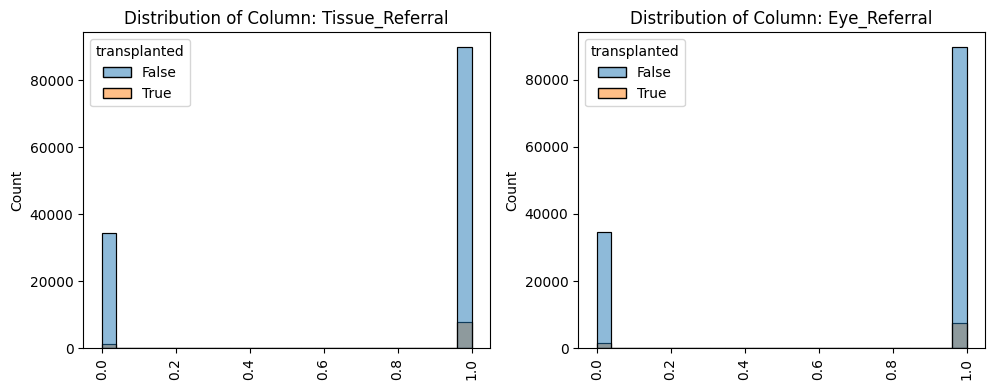

In [ ]:
#Batch process as running this loop on entire dataset causes system to crash

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), sharex=False, sharey=False)
axes = axes.ravel()
cols = df.columns[13:15]

for col, ax in zip(cols, axes):
    sns.histplot(data=df, x=col, hue='transplanted', fill=True, ax=ax)
    ax.tick_params(axis='x', rotation=90)
    ax.set(title=f'Distribution of Column: {col}', xlabel=None)

fig.delaxes(axes[2])  # delete the empty subplot
fig.tight_layout()
plt.show()

#516 value in lung left and right columns - no interpretation available, likely data entry error

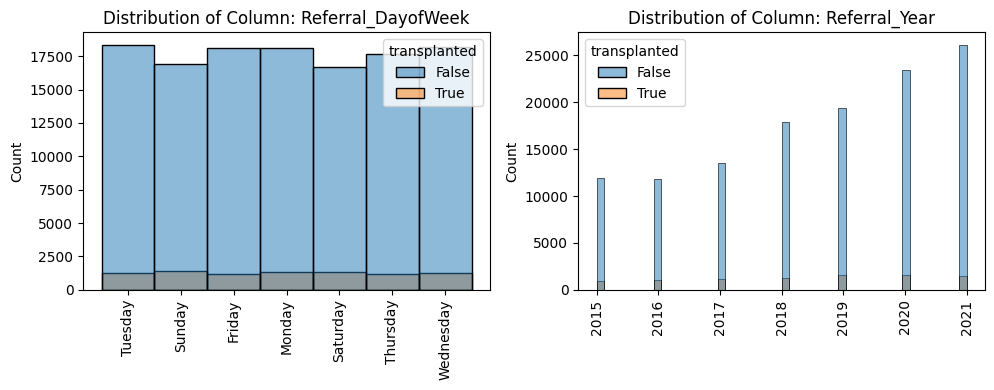

In [ ]:
#Batch process as running this loop on entire dataset causes system to crash

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), sharex=False, sharey=False)
axes = axes.ravel()
cols = df.columns[21:23]

for col, ax in zip(cols, axes):
    sns.histplot(data=df, x=col, hue='transplanted', fill=True, ax=ax)
    ax.tick_params(axis='x', rotation=90)
    ax.set(title=f'Distribution of Column: {col}', xlabel=None)

fig.delaxes(axes[2])  # delete the empty subplot
fig.tight_layout()
plt.show()

#516 value in lung left and right columns - no interpretation available, likely data entry error

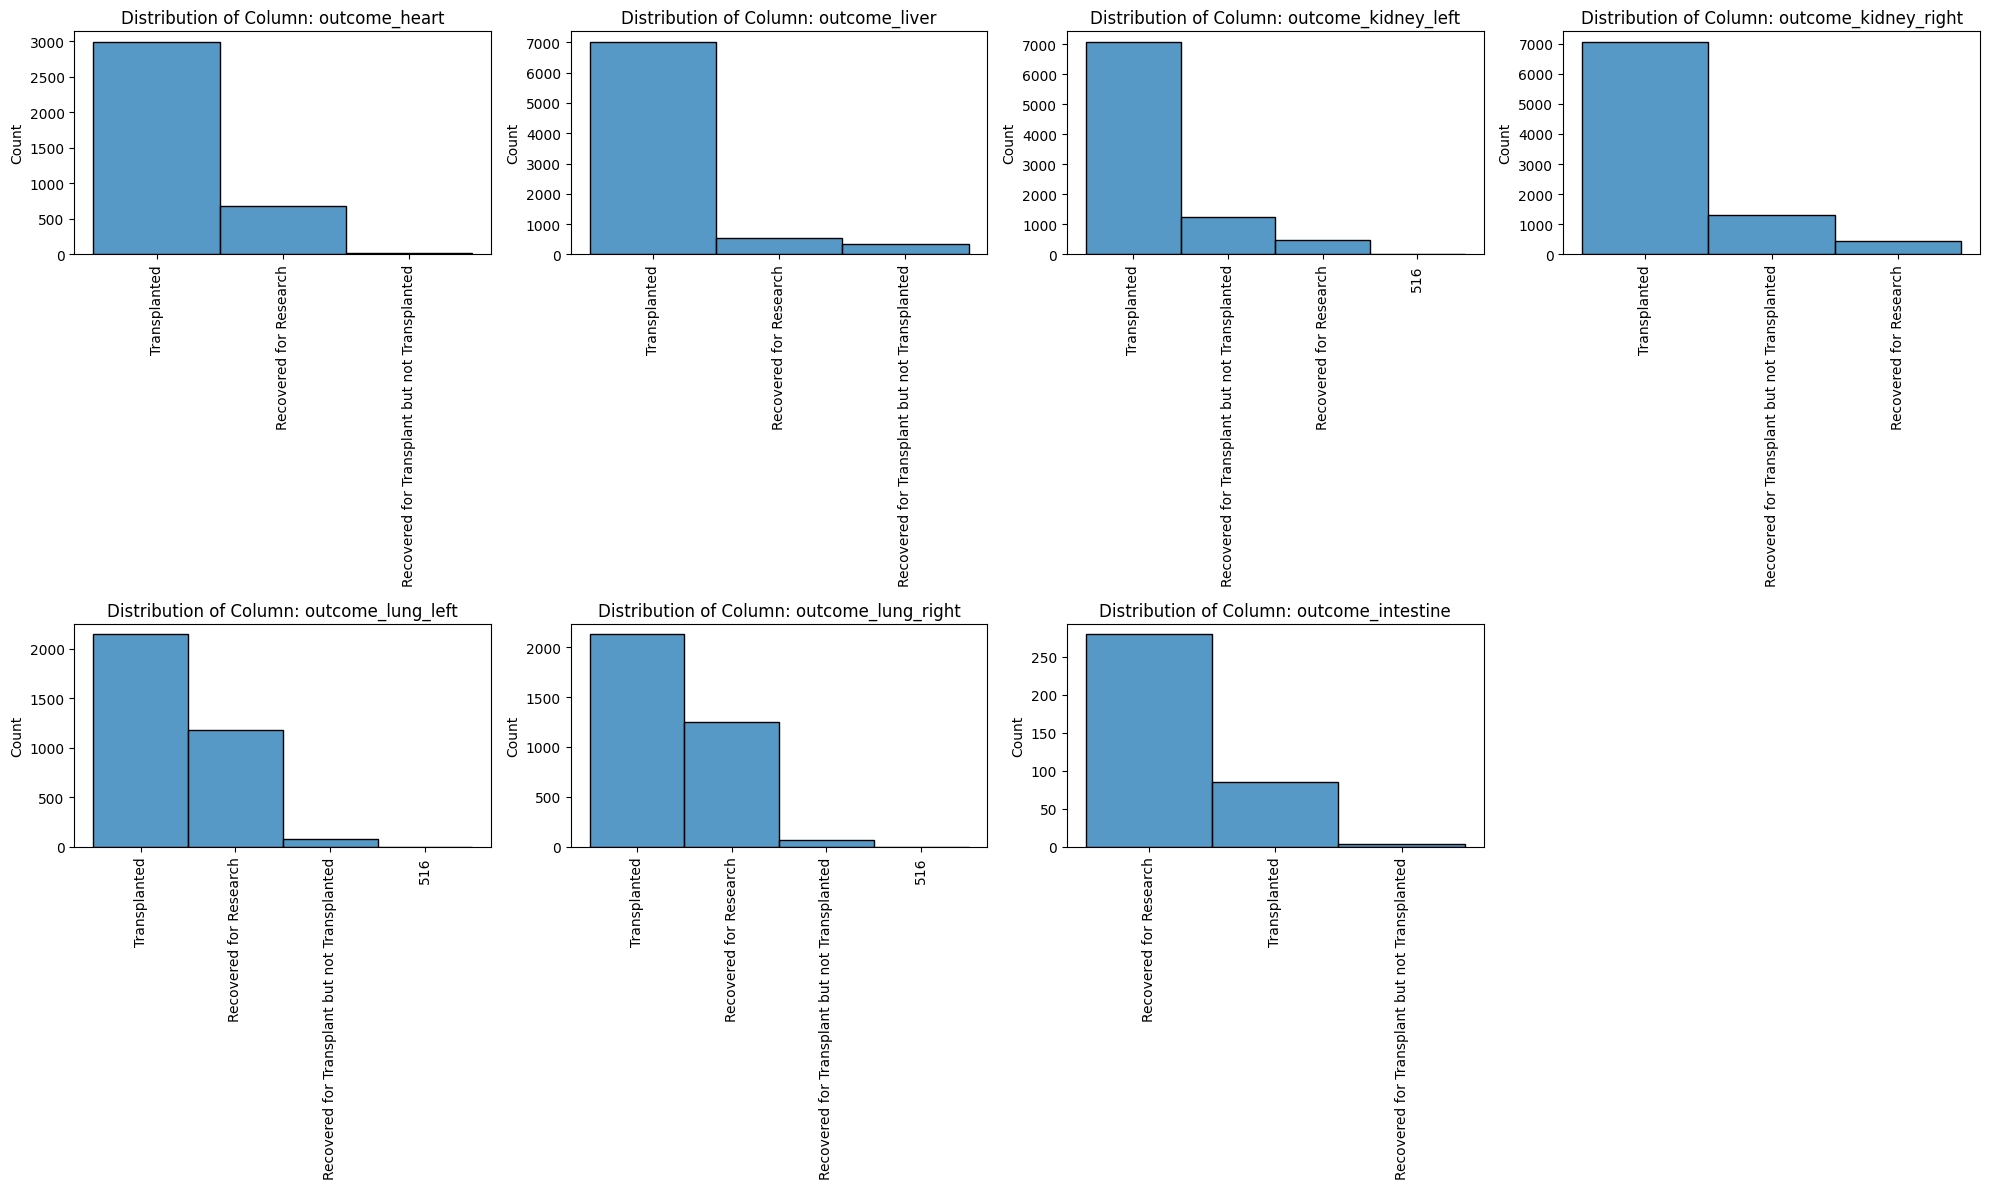

In [ ]:
#Batch process as running this loop on entire dataset causes system to crash

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 12), sharex=False, sharey=False)
axes = axes.ravel()
cols = df.columns[-8:-1]

for col, ax in zip(cols, axes):
    sns.histplot(data=df, x=col, fill=True, ax=ax)
    ax.tick_params(axis='x', rotation=90)
    ax.set(title=f'Distribution of Column: {col}', xlabel=None)

fig.delaxes(axes[7])  # delete the empty subplot
fig.tight_layout()
plt.show()

#516 value in lung left and right columns - no interpretation available, likely data entry error

# Check for multicollinearity

<Axes: >

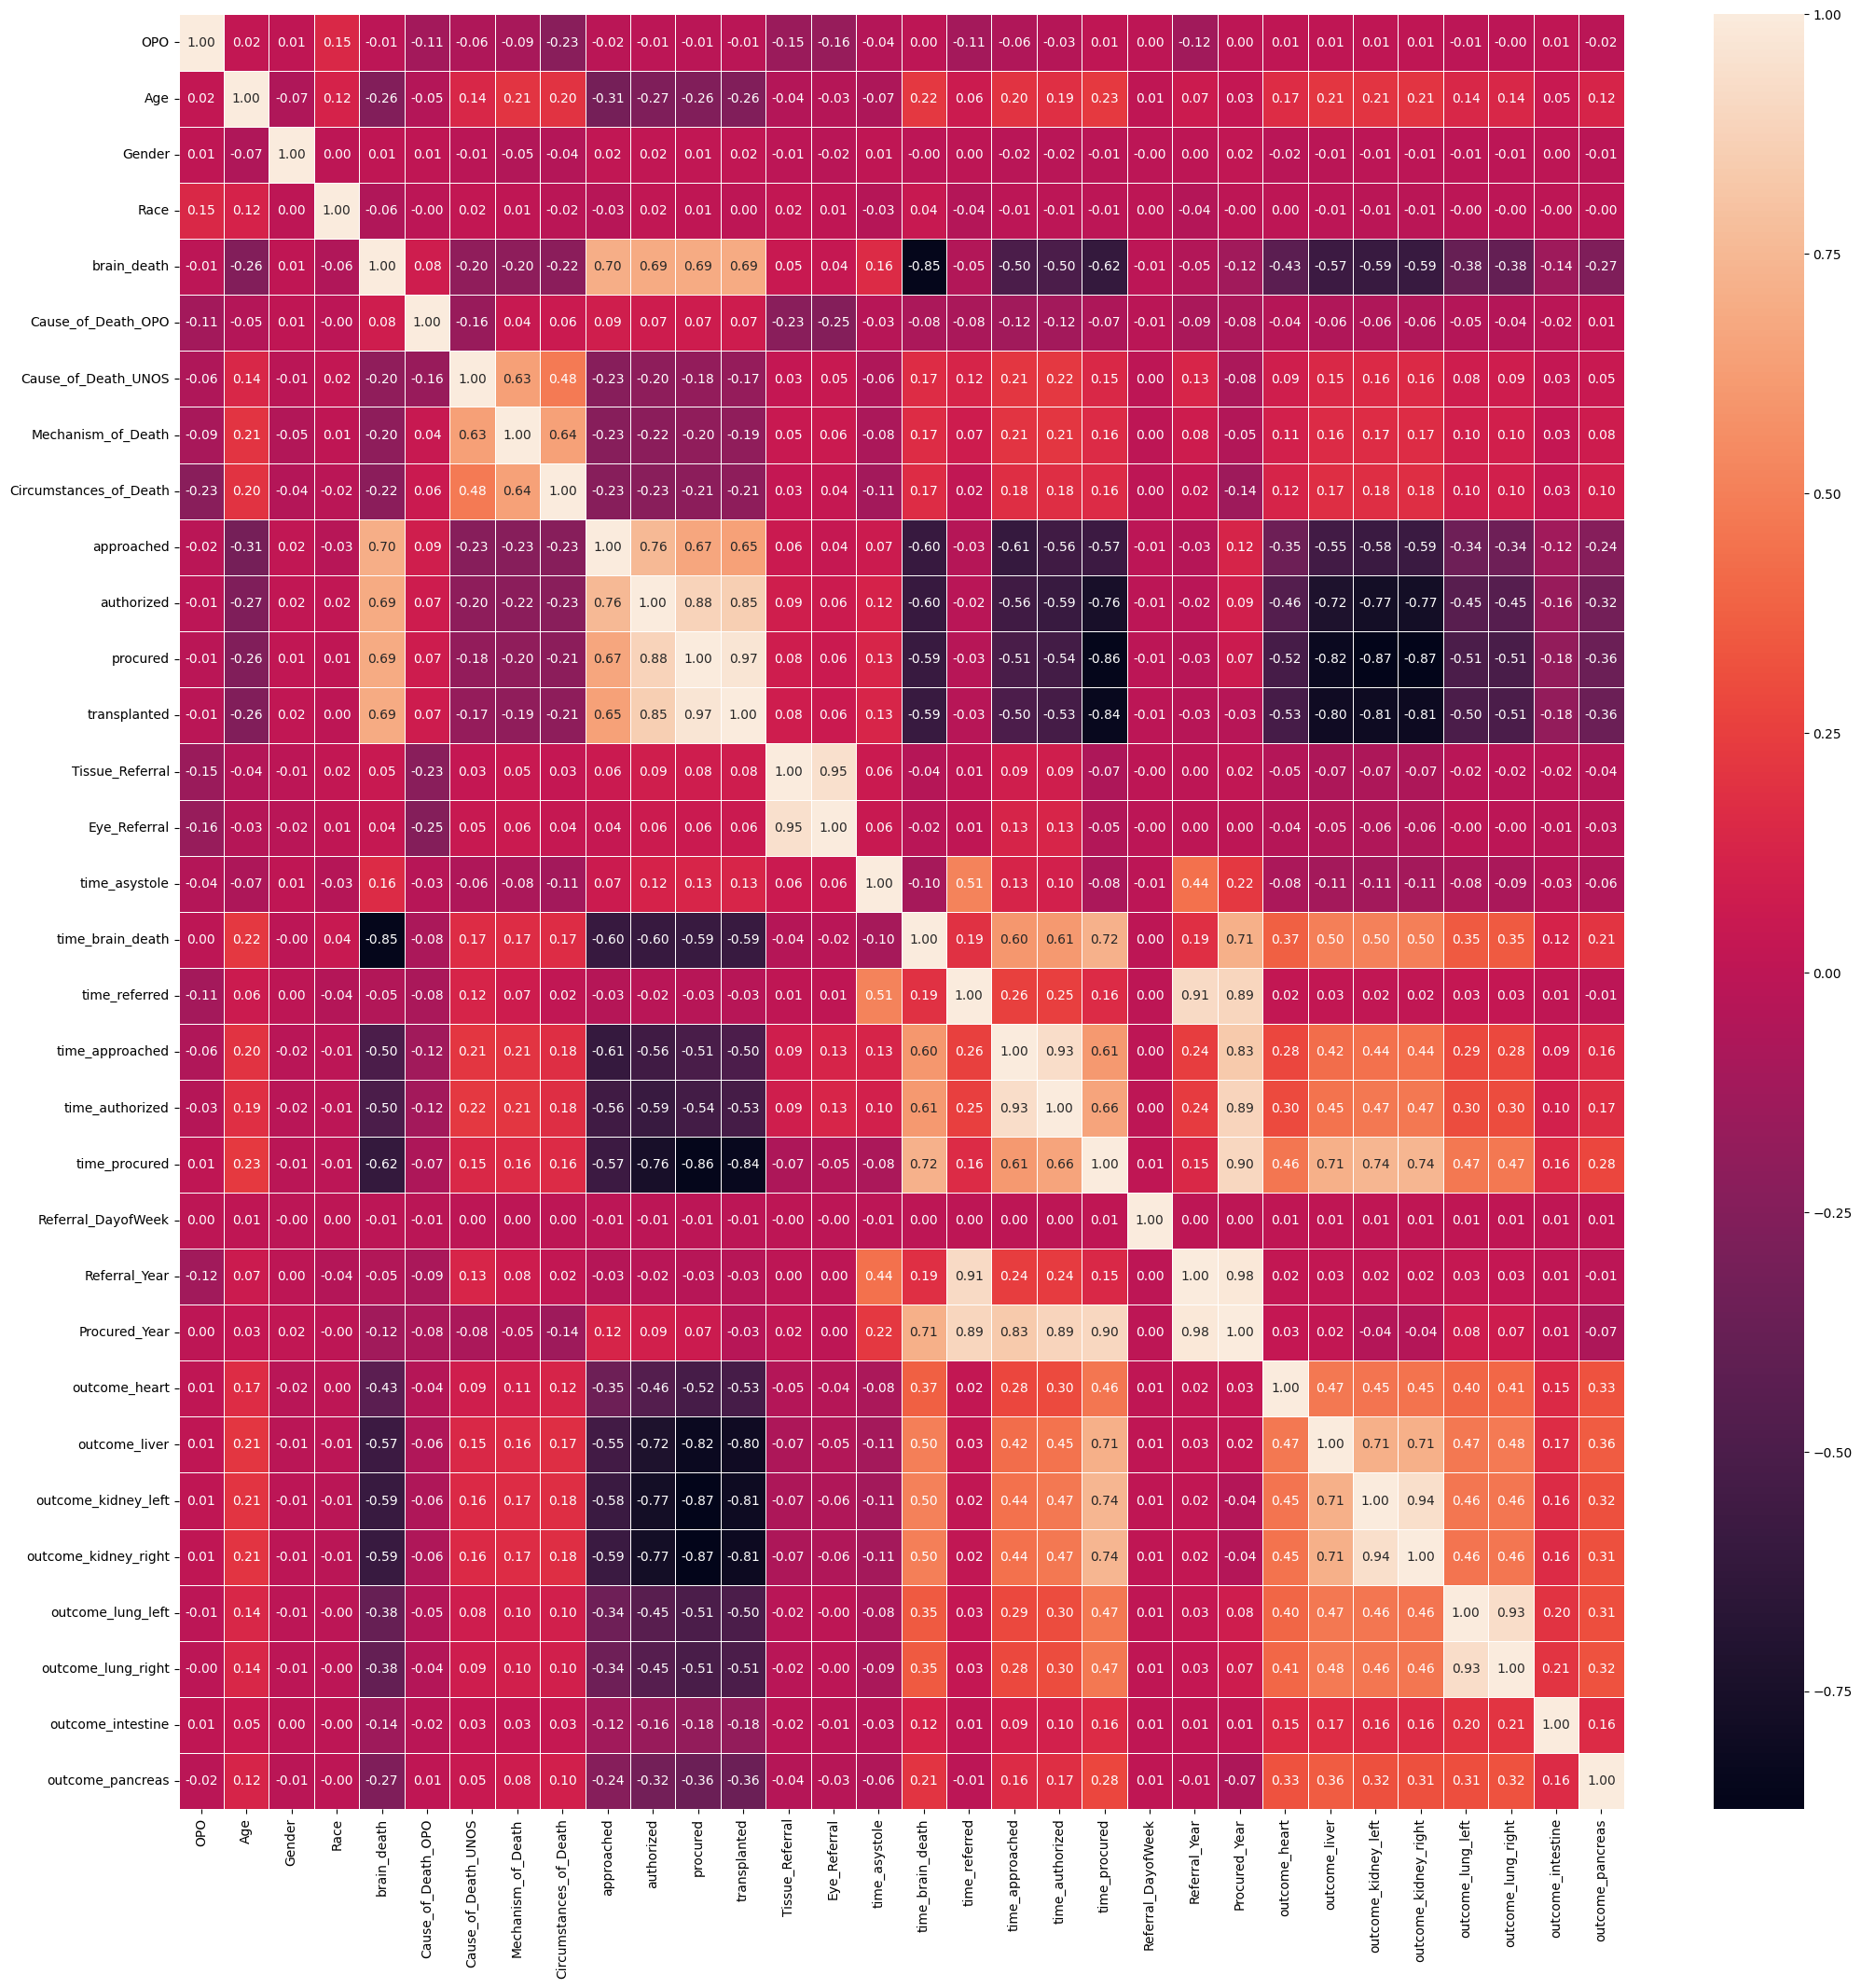

In [ ]:
# Make a copy and encode categorical variables so that we can see correlation between all variables
df_test = df.copy()
# Select only the object columns
object_columns = df_test.select_dtypes(include=['object']).columns

# Apply label encoding to each object column
label_encoder = LabelEncoder()
for column in object_columns:
    df_test[column] = label_encoder.fit_transform(df_test[column])

# Convert the entire DataFrame to float
df_test_copy = df_test.astype(float)

fig, ax = plt.subplots(figsize=(25,25))         # Sample figsize in inches
corr_matrix = df_test_copy.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f",linewidths=.5, ax=ax)

# Feature engineering: WHO
Combining categorical variables using the WHO ICD-11 Disability Assessment framework

In [ ]:
# Make a copy of df before engineering all the features
df_new = df.copy()

In [ ]:
#ICD classification framework to combine certain categories

def total_values(df,col,list_features,label):
  """
  Unifies similar disease categories based on International Classification of Functioning, Disability and Health (ICF)
  classification framework.

    Parameters
    ----------
    df (DataFrame): a Pandas dataframe.
    col (string): column where values are to be categorized/clustered.
    list_features (array): the values that are to be clustered as one label
    label (string): the new label for features

    Returns
    -------
    None

  """

  #Print sum of counts of categories to be clustered together
  #print(sum([(df.loc[df[col] == i]).shape[0] for i in list_features]))

  for i in list_features:
    #print(col,i)
    #Change each column value to the new label based on classification framework
    df[col].mask(df[col]==i, label, inplace=True)
    #df['Mechanism_of_Death'].mask(df['Mechanism_of_Death']=='Death from Natural Causes','Natural Causes', inplace=True)


In [ ]:
#Cluster categories: cause of death (OPO)
print(len(list(df_new['Cause_of_Death_OPO'].unique())))
df['Cause_of_Death_OPO'].value_counts()

81


Cardiac - Other, specify        6511
Other, specify                  5035
Respiratory - Other, specify    4930
Sepsis                          2996
ICB / ICH                       1166
                                ... 
An - smoke inhalation              3
TR - stabbing                      2
PED - abuse/shaken baby            1
TR - electrocution                 1
Poisoning                          1
Name: Cause_of_Death_OPO, Length: 80, dtype: int64

Cluster categories: cause of death OPO

In [ ]:
# Infections
infections=['Sepsis','Septic Shock','Infectious Disease - Bacterial','Infectious Disease - Viral',
            'Infectious Disease - Other, specify','Pneumonia','HIV','Hepatitis','AIDS/HIV']
total_values(df_new,'Cause_of_Death_OPO',infections,'Infectious Disease')

# Cardio
cardio=['CHF','CAR - CHF','AAA or thoracic AA', 'AAA - abdominal aortic aneurysm', 'CAR - cardiomegaly/cardiomyopathy/cardiovascular',
        'Pulmonary embolism','PE--Pulmonary Embolism ','Myocardial infarction',
        'CAR - MI', 'CAR - probable MI', 'CAR - arrhythmia',
        'Arrhythmia','Cardiac - Other, specify']
total_values(df_new,'Cause_of_Death_OPO',cardio,'Circulatory Disease')

# Respiratory
resp=['Anoxia','COPD','RES - COPD', 'Respiratory - Other','Respiratory - Other, specify',
      'RES - other', 'RES - pneumonia', 'RES - lung disease', 'RES - asthma',
      'RES - aspiration']
total_values(df_new,'Cause_of_Death_OPO',resp,'Respiratory Disease')

# Newborn/perinatal
newborn=['Fetal Demise','Prematurity','Sudden infant death syndrome',
         'PED - abuse/shaken baby']
total_values(df_new,'Cause_of_Death_OPO',newborn,'Newborn Disease')

# Cancers
cancers=['Leukemia / Lymphoma','Cancer', 'Cancer - Leukemia/Lymphoma','Cancer/Current or within five years']
total_values(df_new,'Cause_of_Death_OPO',cancers,'Cancer')

# Neurological
neuro=['CVA/Stroke - Cerebro Accident','ICB / ICH', 'Cerebrovascular / Stroke',
       'CNS Tumor','SAH','Meningitis','Seizure/Seizure Disorder', 'Aneurysm',
       ]
total_values(df_new,'Cause_of_Death_OPO',neuro,'Nervous Disease')

# Digestive
digestive=['GI - necrotic bowel','GI - bleed','GI - bowel perforation','GI - bowel obstruction']
total_values(df_new,'Cause_of_Death_OPO',digestive,'Digestive Disease')

# Liver
liver=['Liver Disease/Failure','ESLD']
total_values(df_new,'Cause_of_Death_OPO',liver,'Liver Disease')

# Kidney
kidney=['ESRD','Kidney/Renal  Disease']
total_values(df_new,'Cause_of_Death_OPO',kidney,'Kidney Disease')

# Eye
eye=['PED - other', 'PED - premature']
total_values(df_new,'Cause_of_Death_OPO',eye,'Eye Disease')

# Injuries, mostly external
injury=['GSW','TR - GSW','Drowning','Head Trauma','Trauma','Overdose',
        'Drug Overdose/Probable Drug Abuse','An - other', 'An - asphyixiation',
        'An - smoke inhalation','An -  hanging', 'An - drowning',
        'TR - MVA', 'TR - other', 'TR - other', 'TR - CHI - Closed Head Injury',
        'TR - burns', 'TR - stabbing', 'TR - electrocution','Poisoning',
        'Intracranial Hemorrhage','Exsanguination']
total_values(df_new,'Cause_of_Death_OPO',injury,'Injury_External Causes')

# Multisystem
multi=['Multi-system failure', 'MultiSystem Failure']
total_values(df_new,'Cause_of_Death_OPO',multi,'Multi-system failure')

# Other
other=['Other','Other, specify']
total_values(df_new,'Cause_of_Death_OPO',other,'Other')

# df_new['Cause_of_Death_OPO'].replace(np.nan, 'Not reported/missing', inplace=True)

In [ ]:
print(len(list(df_new['Cause_of_Death_OPO'].unique())))
df_new['Cause_of_Death_OPO'].value_counts() #reduced from 80 to 16 categories

16


Circulatory Disease       7881
Respiratory Disease       6001
Infectious Disease        5385
Other                     5311
Injury_External Causes    2992
Nervous Disease           1934
Cancer                    1127
Multi-system failure       863
Liver Disease              495
Kidney Disease             200
Digestive Disease          107
Natural Causes              42
Unknown COD                 26
Newborn Disease             22
Eye Disease                  9
Name: Cause_of_Death_OPO, dtype: int64

Cluster categories: cause of death

In [ ]:
#Cluster categories: cause of death
print(len(list(df_new['Cause_of_Death_UNOS'].unique())))
df['Cause_of_Death_UNOS'].value_counts()

38


Anoxia                                 40366
Other                                  24264
CVA/Stroke                             17583
Head Trauma                            10820
Infectious Disease - Viral              1822
Sepsis                                  1763
Cerebrovascular / Stroke                1353
Other, specify                           737
Cardiac - Other, specify                 701
Respiratory - Other, specify             679
ESLD                                     590
CNS Tumor                                454
Pneumonia                                416
Cancer                                   312
ICB / ICH                                201
Infectious Disease - Bacterial           155
AAA or thoracic AA                       119
Infectious Disease - Other, specify      114
CHF                                      111
Overdose                                  88
COPD                                      86
Trauma                                    84
Exsanguina

In [ ]:
#Cluster categories: cause of death UNOS

infections=['Sepsis','Infectious Disease - Bacterial','Infectious Disease - Viral','Infectious Disease - Other, specify','Pneumonia','HIV','Hepatitis']
total_values(df_new,'Cause_of_Death_UNOS',infections,'Infectious Disease')

cardio=['CHF','AAA or thoracic AA', 'Pulmonary embolism','Myocardial infarction','Arrhythmia','Cardiac - Other, specify']
total_values(df_new,'Cause_of_Death_UNOS',cardio,'Circulatory Disease')

resp=['Anoxia','COPD','Respiratory - Other','Respiratory - Other, specify']
total_values(df_new,'Cause_of_Death_UNOS',resp,'Respiratory Disease')

newborn=['Fetal Demise','Prematurity','Sudden infant death syndrome']
total_values(df_new,'Cause_of_Death_UNOS',newborn,'Newborn Disease')

cancers=['Leukemia / Lymphoma','Cancer']
total_values(df_new,'Cause_of_Death_UNOS',cancers,'Cancer')

neuro=['CVA/Stroke','ICB / ICH', 'Cerebrovascular / Stroke', 'CNS Tumor','SAH']
total_values(df_new,'Cause_of_Death_UNOS',neuro,'Nervous Disease')

injury=['GSW','Drowning','Head Trauma','Trauma','Overdose',
        'Exsanguination']
total_values(df_new,'Cause_of_Death_UNOS',injury,'Injury_External Causes')

other=['Other','Other, specify']
total_values(df_new,'Cause_of_Death_UNOS',other,'Other')

# Replace names to keep consistent with OPO category change
df_new['Cause_of_Death_UNOS'].replace('ESRD', 'Kidney Disease', inplace=True)
df_new['Cause_of_Death_UNOS'].replace('ESLD', 'Liver Disease', inplace=True)

In [ ]:
print(len(list(df_new['Cause_of_Death_UNOS'].unique())))
df_new['Cause_of_Death_UNOS'].value_counts() #reduced to 11 categories

12


Respiratory Disease       41131
Other                     25001
Nervous Disease           19620
Injury_External Causes    11123
Infectious Disease         4302
Circulatory Disease        1054
Liver Disease               590
Cancer                      324
Kidney Disease               68
Multi-system failure         45
Newborn Disease              24
Name: Cause_of_Death_UNOS, dtype: int64

Cluster categories: mechanism of death

In [ ]:
# Cluster categories: mechanism of death
print(len(list(df_new['Mechanism_of_Death'].unique())))
df['Mechanism_of_Death'].value_counts()

20


Cardiovascular                       27266
Natural Causes                       25884
ICH/Stroke                           16476
None of the Above                     8755
Blunt Injury                          8313
Drug Intoxication                     3285
Gun Shot Wound                        1992
Asphyxiation                          1939
Intracranial Hemmorrhage / Stroke     1311
Death from Natural Causes              890
Seizure                                775
Drug / Intoxication                    546
Drowning                               507
Gunshot Wound                          297
Other                                  112
Stab                                    76
Electrical                              51
Sudden Infant Death                     41
None of the above                       16
Name: Mechanism_of_Death, dtype: int64

In [ ]:
# Cluster categories: mechanism of death

# Taking only natural causes
natural_causes=['Natural Causes','Death from Natural Causes']
total_values(df_new,'Mechanism_of_Death',natural_causes,'Natural Causes')

# Taking only injuries and external causes: blunt injury, drug intoxication, gunshot wound, asphyxiation, drowning, stab, electrical
injury_external=['Blunt Injury','Drug Intoxication','Gun Shot Wound','Asphyxiation','Drug / Intoxication',
                 'Drowning','Gunshot Wound','Stab','Electrical']
total_values(df_new,'Mechanism_of_Death',injury_external,'Injury_External Causes')

# Taking only nervous system related disorders: stroke, seizure
nervous_diseases=['ICH/Stroke','Intracranial Hemmorrhage / Stroke','Seizure']
total_values(df_new,'Mechanism_of_Death',nervous_diseases,'Nervous Disease')

# None of the above
nofa=['None of the Above','None of the above']
total_values(df_new,'Mechanism_of_Death',nofa,'Other')

In [ ]:
print(len(list(df_new['Mechanism_of_Death'].unique())))
df_new['Mechanism_of_Death'].value_counts() #reduced to 7 categories

7


Cardiovascular            27266
Natural Causes            26774
Nervous Disease           18562
Injury_External Causes    17006
Other                      8883
Sudden Infant Death          41
Name: Mechanism_of_Death, dtype: int64

Cluster categories: Circumstances of Death

In [ ]:
# Cluster categories: Circumstances of Death
print(len(list(df_new['Circumstances_of_Death'].unique())))
df['Circumstances_of_Death'].value_counts()

15


Natural Causes                60699
None of the Above             17859
Accident, Non-MVA              6446
MVA                            5045
Death from Natural Causes      3470
Suicide                        2282
Homicide                       1293
Motor Vehicle Accident          481
Non-Motor Vehicle Accident      336
Alleged Suicide                 293
Alleged Homicide                141
Child Abuse                     127
Other                            95
Alleged Child Abuse              20
Name: Circumstances_of_Death, dtype: int64

In [ ]:
# Cluster categories: Circumstances of Death

# Taking only natural causes
natural_causes=['Natural Causes','Death from Natural Causes']
total_values(df_new,'Circumstances_of_Death',natural_causes,'Natural Causes')

# Taking only motor vehicle accidents
mva=['Motor Vehicle Accident','MVA']
total_values(df_new,'Circumstances_of_Death',mva,'Motor Accident')

# Taking only non-motor vehicle accidents
non_mva=['Non-Motor Vehicle Accident','Accident, Non-MVA']
total_values(df_new,'Circumstances_of_Death',non_mva,'Non-motor Accident')

# Suicide - real or alleged
suicide=['Suicide','Alleged Suicide']
total_values(df_new,'Circumstances_of_Death',suicide,'Suicide')

# Homicide - real or alleged
homicide=['Homicide','Alleged Homicide']
total_values(df_new,'Circumstances_of_Death',homicide,'Homicide')

# Child Abuse - real or alleged
child_abuse=['Child Abuse','Alleged Child Abuse']
total_values(df_new,'Circumstances_of_Death',child_abuse,'Homicide')

# Other/none of the above
other=['Other','None of the Above']
total_values(df_new,'Circumstances_of_Death',other,'Other')

In [ ]:
print(len(list(df_new['Circumstances_of_Death'].unique())))
df_new['Circumstances_of_Death'].value_counts() #reduced to 7 categories

7


Natural Causes        64169
Other                 17954
Non-motor Accident     6782
Motor Accident         5526
Suicide                2575
Homicide               1581
Name: Circumstances_of_Death, dtype: int64

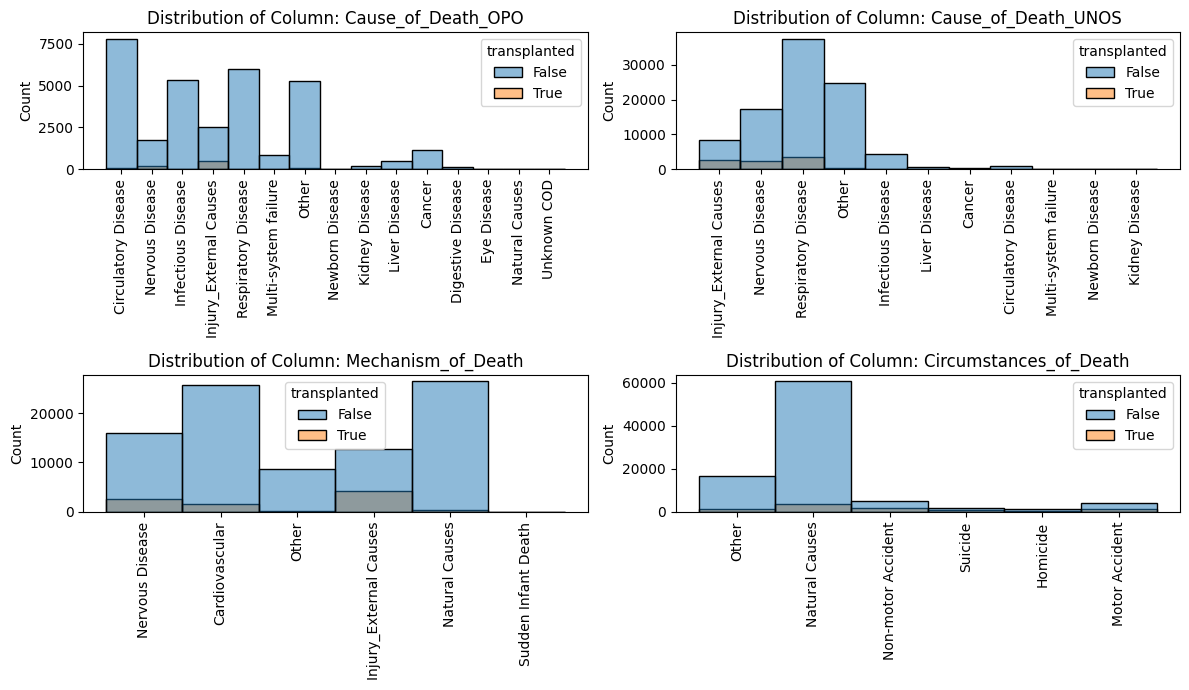

In [ ]:
#After clustering categories for 3 features: plot results

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 7), sharex=False, sharey=False)
axes = axes.ravel()
cols = df_new.columns[5:9]

for col, ax in zip(cols, axes):
    sns.histplot(data=df_new, x=col, hue='transplanted', fill=True, ax=ax)
    ax.tick_params(axis='x', rotation=90)
    ax.set(title=f'Distribution of Column: {col}', xlabel=None)

#fig.delaxes(axes[3])  # delete the empty subplot
fig.tight_layout()
plt.show()

# Feature engineering: combine tissue/eye referral
Deals with collinearity of these variables

In [ ]:
# Combine Tissue_Referral and Eye_Referral because they are almost perfectly collinear
df_new['tissue_eye_referral'] = df_new.apply(lambda x: (x['Tissue_Referral'] and x['Eye_Referral']), axis=1)

# Drop the individual features
df_new = df_new.drop(['Tissue_Referral', 'Eye_Referral'],axis=1)


# Feature engineering: dealing with time

Although the raw timestamps were deliberately falsified by the research team to protect identity, the intervals between them were kept the same. Here I create new variables
based on the intervals between different timepoints leading to organ transplantation.

In [ ]:
def get_duration_between_dates(then, now, interval = "default"):

    """
    Returns a duration as specified by variable interval.
    Used to calculate new feature of time authorized - time approached.

    Code source: https://stackoverflow.com/questions/1345827/how-do-i-find-the-time-difference-between-two-datetime-objects-in-python

    Parameters
    ----------
    then (DateTime): a date-time.
    now (DateTime): another date-time.
    interval (string): type of duration metric, e.g. minutes.

    Returns
    -------
    (float): A float with the duration in interval units.
    """

    duration = now - then # For build-in functions
    duration_in_s = duration.total_seconds()

    def years():
      return divmod(duration_in_s, 31536000) # Seconds in a year=31536000.

    def days(seconds = None):
      return divmod(seconds if seconds != None else duration_in_s, 86400) # Seconds in a day = 86400

    def hours(seconds = None):
      return divmod(seconds if seconds != None else duration_in_s, 3600) # Seconds in an hour = 3600

    def minutes(seconds = None):
      return divmod(seconds if seconds != None else duration_in_s, 60) # Seconds in a minute = 60

    def seconds(seconds = None):
      if seconds != None:
        return divmod(seconds, 1)
      return duration_in_s

    def totalDuration():
        y = years()
        d = days(y[1]) # Use remainder to calculate next variable
        h = hours(d[1])
        m = minutes(h[1])
        s = seconds(m[1])

        return "Time between dates: {} years, {} days, {} hours, {} minutes and {} seconds".format(int(y[0]), int(d[0]), int(h[0]), int(m[0]), int(s[0]))

    return {
        'years': float(years()[0]),
        'days': float(days()[0]),
        'hours': float(hours()[0]),
        'minutes': float(minutes()[0]),
        'seconds': float(seconds()),
        'default': totalDuration()
    }



In [ ]:
def create_time_column(df,col1,col2,new_col_name):
  """
  Create new column to describe the number of hours between administrative milestones,
  e.g. between referral (death) and approach.

  Parameters
  ----------
  df (DataFrame): input data.
  col1 (string): name of column representing one timepoint.
  col2 (string): name of column representing another timepoint.
  new_col_name (string): new column name representing a time category between time points.

  Returns
  -------
  df (DataFrame): modified df with new column.

  """
  def convert_datetime(str1,str2):
    # Helper function to convert to datetime
    return [pd.to_datetime(str1), pd.to_datetime(str2)]

  time_category = []
  for row in zip(df[col1], df[col2]):
    if pd.isnull(row[0])==False and pd.isnull(row[1])==False:
      date_row=convert_datetime(row[0],row[1])
      time_elapsed=abs(get_duration_between_dates(date_row[0],date_row[1])['hours'])

      if time_elapsed <= 24:
        time_category.append('Within 24 hours')

      if time_elapsed > 24:
        time_category.append('Over 24 hours')

    else:
      time_category.append('Milestone not reached')

  df[new_col_name]=time_category

  return df

Add time interval variables

In [ ]:
# Define timepoint variables
time_vars = ['time_asystole','time_brain_death','time_referred', 'time_approached', 'time_authorized', 'time_procured']

# Get category of intervals between them
asystole_to_referred = 'time_asystole_to_referred'
df_new = create_time_column(df_new,time_vars[0],time_vars[2], asystole_to_referred)

brain_death_to_referred = 'time_brain_death_to_referred'
df_new = create_time_column(df_new,time_vars[1],time_vars[2], brain_death_to_referred)

referred_to_approached = 'time_referred_to_approached'
df_new = create_time_column(df_new,time_vars[2],time_vars[3], referred_to_approached)

approached_to_authorized = 'time_approached_to_authorized'
df_new = create_time_column(df_new,time_vars[3],time_vars[4], approached_to_authorized)

authorized_to_procured = 'time_authorized_to_procured'
df_new = create_time_column(df_new,time_vars[4],time_vars[5], authorized_to_procured)

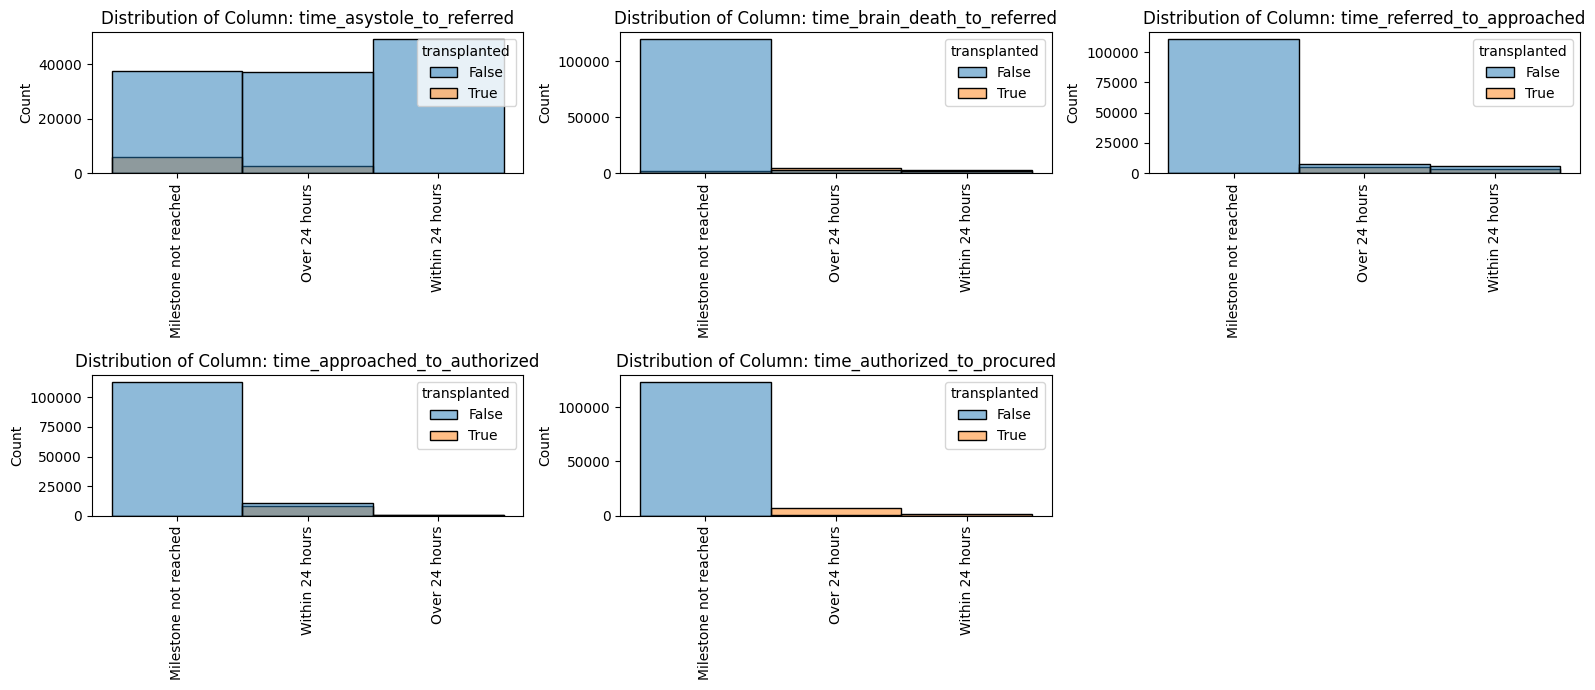

In [ ]:
# Plot the new variables' distribution
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16,7), sharex=False, sharey=False)
axes = axes.ravel()
cols = df_new.columns[-5:] # plot new vars

for col, ax in zip(cols, axes):
    sns.histplot(data=df_new, x=col, hue='transplanted', fill=True, ax=ax)
    ax.tick_params(axis='x', rotation=90)
    ax.set(title=f'Distribution of Column: {col}', xlabel=None)

fig.delaxes(axes[5])  # delete the empty subplot
fig.tight_layout()
plt.show()

In [ ]:
df_new['time_authorized_to_procured'].value_counts()

Milestone not reached    123568
Over 24 hours              7915
Within 24 hours            1618
Name: time_authorized_to_procured, dtype: int64

# Correlation with all new vars

In [ ]:
df_test=df_new.copy()

In [ ]:
# Select only the object columns
object_columns = df_test.select_dtypes(include=['object']).columns

# Apply label encoding to each object column
label_encoder = LabelEncoder()
for column in object_columns:
    df_test[column] = label_encoder.fit_transform(df_test[column])

# Convert the entire DataFrame to float
df_test_copy = df_test.astype(float)

<Axes: >

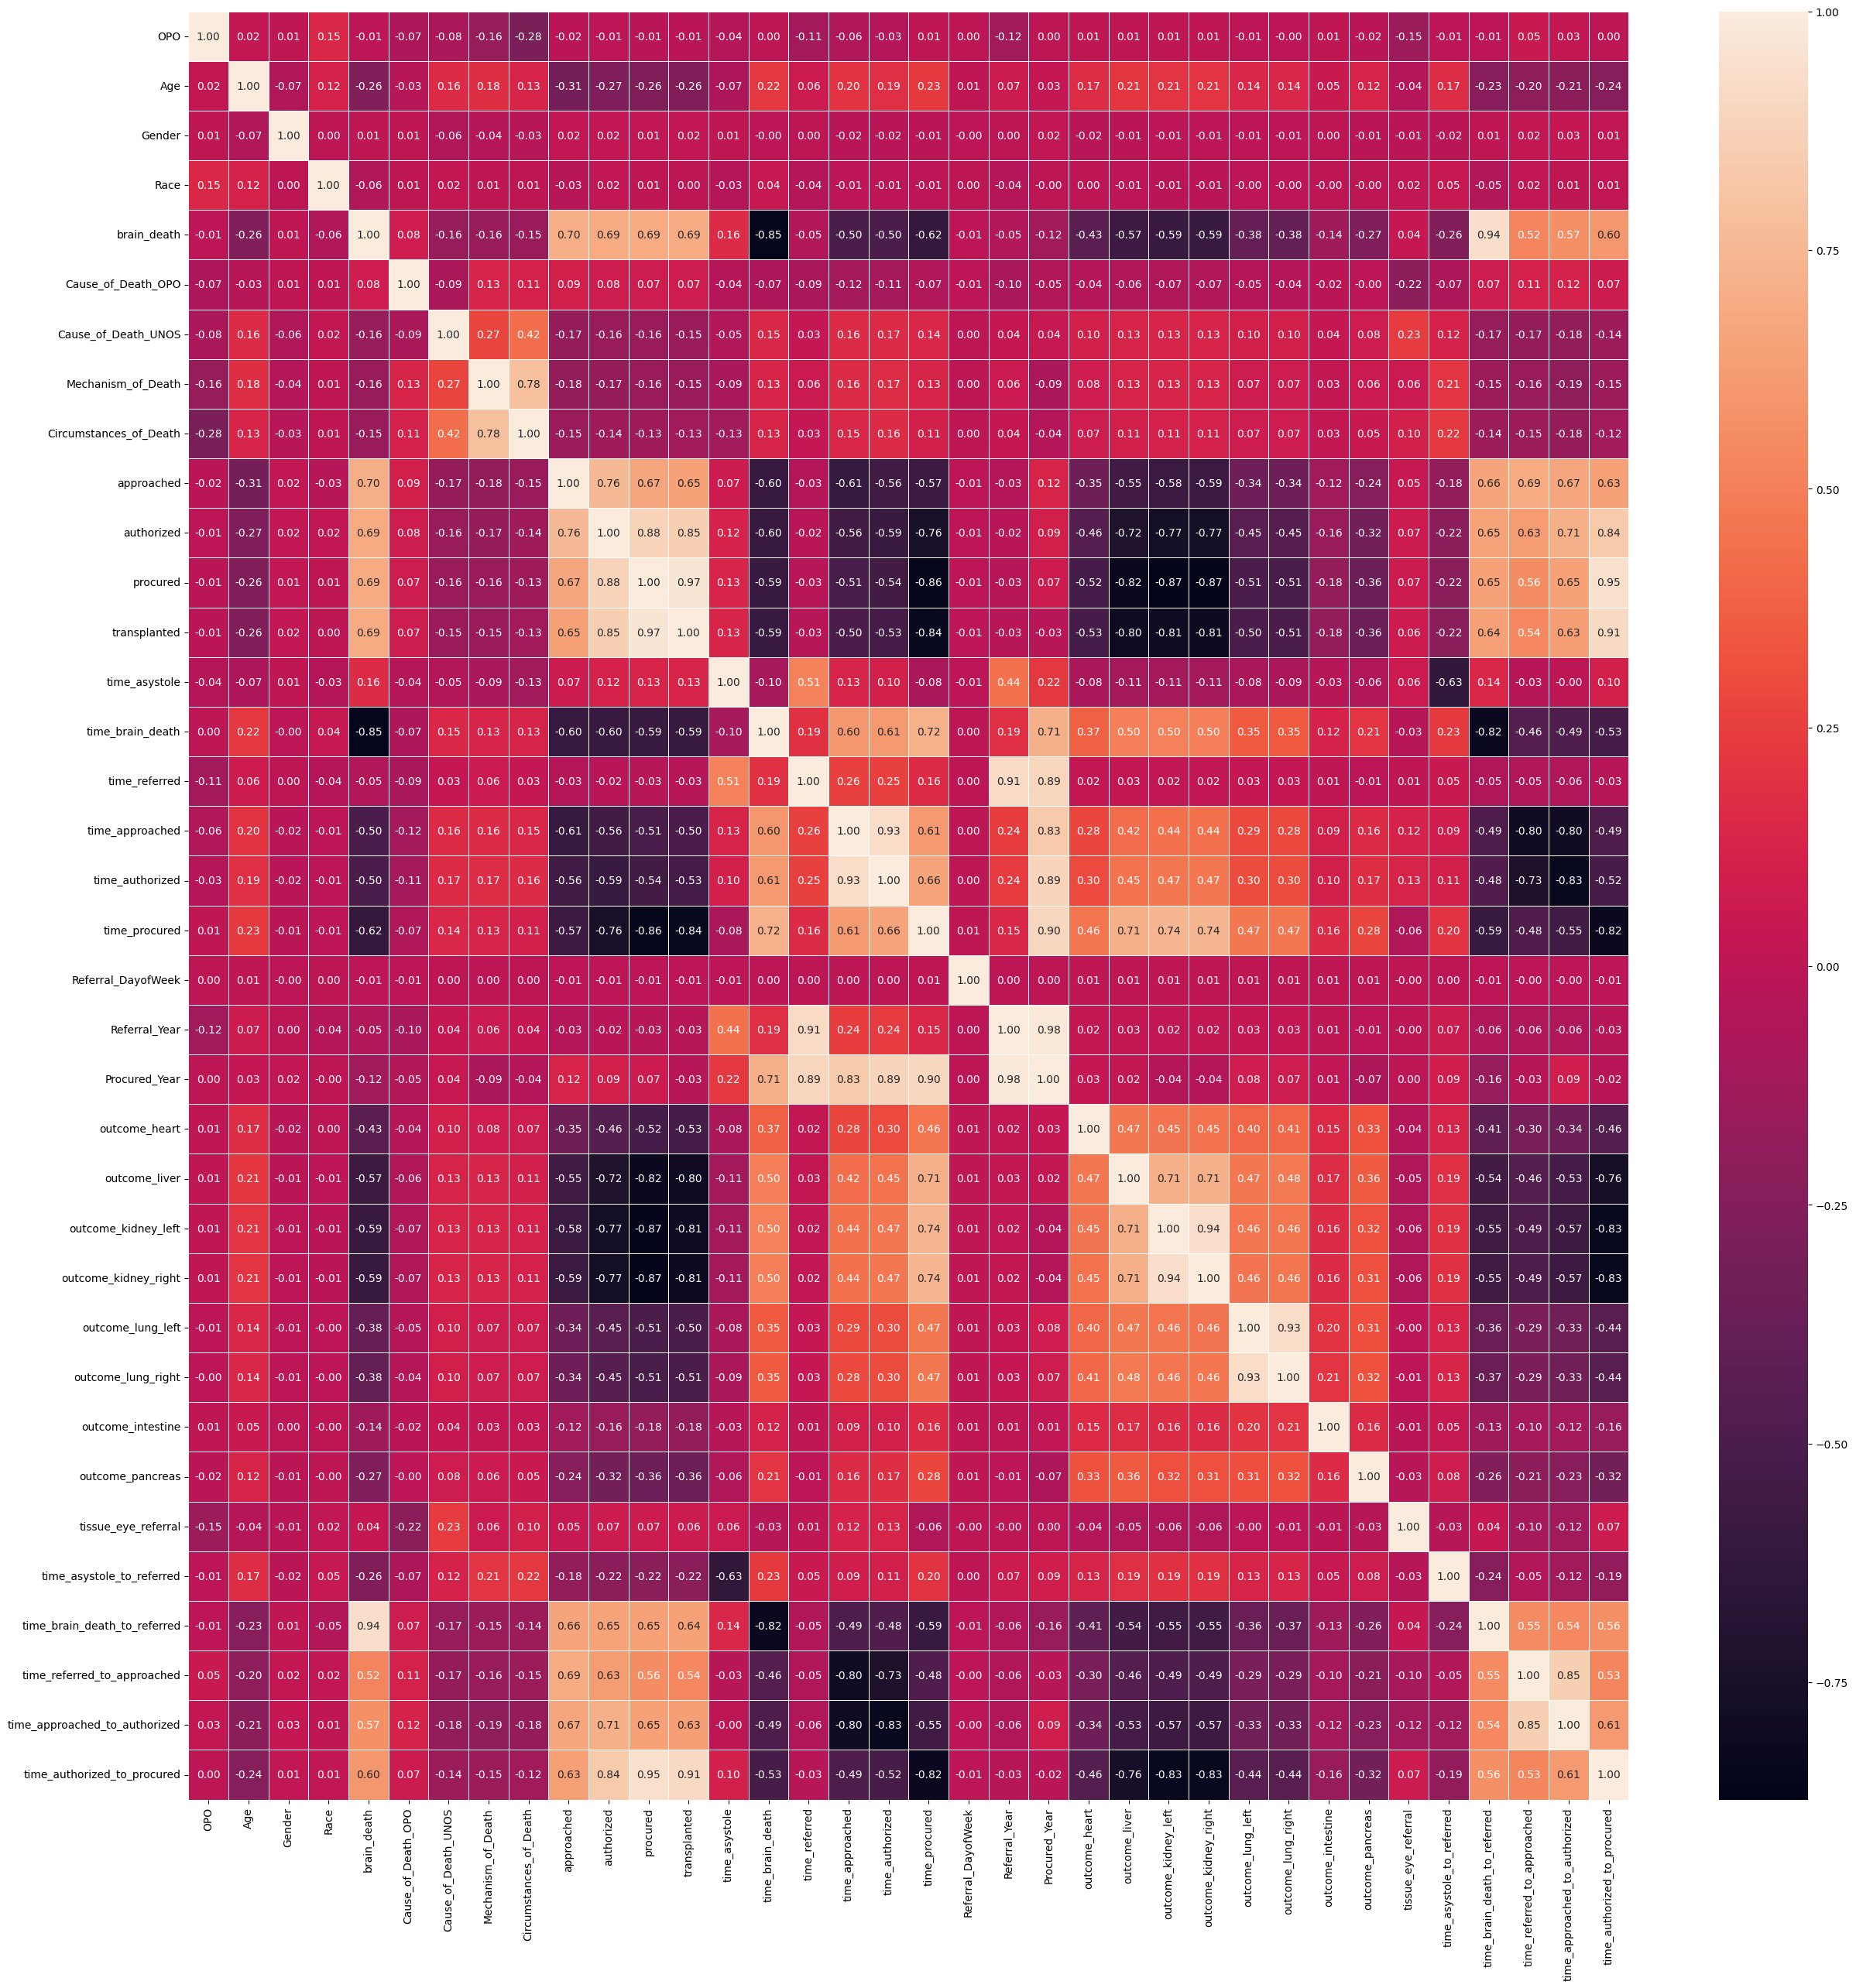

In [ ]:
fig, ax = plt.subplots(figsize=(30,30))         # Sample figsize in inches
corr_matrix2 = df_test.corr()
sns.heatmap(corr_matrix2, annot=True, fmt=".2f",linewidths=.5, ax=ax)

# Create this copy for Q2 before proceeding with below

In [ ]:
# Store this copy for question 2 - we need the outcome organ variables
df_new2=df_new.copy()

# Dropping features

In [ ]:
#Features we have
df_new.columns

Index(['OPO', 'Age', 'Gender', 'Race', 'brain_death', 'Cause_of_Death_OPO',
       'Cause_of_Death_UNOS', 'Mechanism_of_Death', 'Circumstances_of_Death',
       'approached', 'authorized', 'procured', 'transplanted', 'time_asystole',
       'time_brain_death', 'time_referred', 'time_approached',
       'time_authorized', 'time_procured', 'Referral_DayofWeek',
       'Referral_Year', 'Procured_Year', 'outcome_heart', 'outcome_liver',
       'outcome_kidney_left', 'outcome_kidney_right', 'outcome_lung_left',
       'outcome_lung_right', 'outcome_intestine', 'outcome_pancreas',
       'tissue_eye_referral', 'time_asystole_to_referred',
       'time_brain_death_to_referred', 'time_referred_to_approached',
       'time_approached_to_authorized', 'time_authorized_to_procured'],
      dtype='object')

In [ ]:
# Drop time variables and keep (some of) the time interval variables
cols_large_missing.remove('Cause_of_Death_OPO') # Keep this as it is still domain relevant
df_new = df_new.drop(cols_large_missing,axis=1) # drop Procured_Year as it is almost perfectly collinear with Referral_Year (0.98)

In [ ]:
#Features we have after dropping
df_new.columns

Index(['OPO', 'Age', 'Gender', 'Race', 'brain_death', 'Cause_of_Death_OPO',
       'Cause_of_Death_UNOS', 'Mechanism_of_Death', 'Circumstances_of_Death',
       'approached', 'authorized', 'procured', 'transplanted', 'time_asystole',
       'time_referred', 'Referral_DayofWeek', 'Referral_Year',
       'tissue_eye_referral', 'time_asystole_to_referred',
       'time_brain_death_to_referred', 'time_referred_to_approached',
       'time_approached_to_authorized', 'time_authorized_to_procured'],
      dtype='object')

In [ ]:
# Make this copy before we remove collinear variables >0.8
df_new_with_collinear=df_new.copy()

In [ ]:
df_new_with_collinear.columns

Index(['OPO', 'Age', 'Gender', 'Race', 'brain_death', 'Cause_of_Death_OPO',
       'Cause_of_Death_UNOS', 'Mechanism_of_Death', 'Circumstances_of_Death',
       'approached', 'authorized', 'procured', 'transplanted', 'time_asystole',
       'time_referred', 'Referral_DayofWeek', 'Referral_Year',
       'tissue_eye_referral', 'time_asystole_to_referred',
       'time_brain_death_to_referred', 'time_referred_to_approached',
       'time_approached_to_authorized', 'time_authorized_to_procured'],
      dtype='object')

In [ ]:
cols_collinear = ['brain_death','time_referred','time_asystole','authorized','procured','time_approached_to_authorized']
df_new = df_new.drop(cols_collinear,axis=1)

In [ ]:
print(len(df_new.columns))
df_new.columns

17


Index(['OPO', 'Age', 'Gender', 'Race', 'Cause_of_Death_OPO',
       'Cause_of_Death_UNOS', 'Mechanism_of_Death', 'Circumstances_of_Death',
       'approached', 'transplanted', 'Referral_DayofWeek', 'Referral_Year',
       'tissue_eye_referral', 'time_asystole_to_referred',
       'time_brain_death_to_referred', 'time_referred_to_approached',
       'time_authorized_to_procured'],
      dtype='object')

# Important functions

In [ ]:
# Define a function to compute various scores for model evaluation
def get_scores(Y_pred, Y):
    """
    Gets classification scores.

      Parameters
      ----------
      Y_pred (array): list of predictive values.
      Y (array): list of ground truth values.

      Returns
      -------
      conf_matrix (Matrix): confusion matrix for model predictions vs actual.
      class_report (dict): class report for model predictions vs actual.
      auc (float): AUC value for model prediction.

    """
    # Calculate confusion matrix, classification report, ROC AUC
    conf_matrix = confusion_matrix(Y_pred, Y)
    class_report = classification_report(Y_pred, Y, output_dict=True)
    auc = roc_auc_score(Y_pred, Y)

    # Return the computed scores
    return conf_matrix, class_report, auc

# Define a function to print the computed scores
def print_scores(conf_matrix, class_report, auc):
    """
    Prints scores.

      Parameters
      ----------
      conf_matrix (Matrix): confusion matrix for model predictions vs actual.
      class_report (string): class report for model predictions vs actual.
      auc (float): AUC value of model.

      Returns
      -------
      None

    """
    print('AUC : ', auc)
    print("Confusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)

Functions to do with identifying variable types/indices

In [ ]:
def get_categorical_cols(df):
  """
  Returns categorical column names.

  Parameters
  ----------
  df (DataFrame): DataFrame with feature columns.

  Returns
  -------
  List of categorical columns.

  """

  # For one hot encoding
  cats = ([col for col in df.columns if
           (df[col].dtype=='object') and col not in ['OPO','Referral_DayofWeek']])
  return cats

def get_numerical_cols(df):
  """
  Returns numerical column names.

  Parameters
  ----------
  df (DataFrame): DataFrame with feature columns.

  Returns
  -------
  List of numerical columns.

  """
  return ([col for col in df.columns if df[col].dtype=='float'])

def get_ordinal_cols(df):
  """
  Returns ordinal column names.

  Parameters
  ----------
  df (DataFrame): DataFrame with feature columns.

  Returns
  -------
  List of ordinal columns.

  """
  other_ordinals=['OPO','Referral_DayofWeek', 'Referral_Year']#, 'Procured_Year']
  return ([col for col in df.columns if (df[col].dtype=='bool' or col in other_ordinals) and
           col!='transplanted'])

def get_list_indices(df,categorical_columns,numerical_columns,ordinal_columns):
  """
  Returns categorical and numerical column indices.

  Parameters
  ----------
  df (DataFrame): DataFrame with feature columns.
  categorical_columns (DataFrame): DataFrame with categorical columns
  numerical_columns (DataFrame): DataFrame with numerical columns
  ordinal_columns (DataFrame): DataFrame with ordinal columns

  Returns
  -------
  cat_index_list (List): list of categorical indices.
  num_index_list (List): list of numerical indices.
  ord_index_list (List): list of ordinal indices.

  """
  cat_index_list=[]
  num_index_list=[]
  ord_index_list=[]
  for index,col in enumerate(df.columns):
    if col in categorical_columns:
      cat_index_list.append(index)
    elif col in numerical_columns:
      num_index_list.append(index)
    elif col in ordinal_columns:
      ord_index_list.append(index)

  return cat_index_list, num_index_list, ord_index_list

# Pipeline with nested CV

In [ ]:
def run_pipeline(X_train,y_train,cat_index_list,num_index_list,ord_index_list,model,param_grid,
                 sample='no-smote'):
  """
  Builds pipeline and performs nested cross-validation on the training set.

  Parameters
  ----------
  X_train (array): training set, predictor variables.
  y_train (array): training set, outcome variable.
  cat_index_list (List): list of categorical indices.
  num_index_list (List): list of numerical indices.
  ord_index_list (List): list of ordinal indices.
  model (Model): classification model, e.g. KNN, LR, RF, SVM
  param_grid (dict): parameter grid for hyperparameter search
  sample (String): to determine whether re-sampling should be applied.

  Returns
  -------
  (DataFrame): evaluation metrics for cross-validation on validation set.

  """

  st=time.time()

  scoring = {'recall0': make_scorer(recall_score, average = None, labels = [0]),
            'recall1': make_scorer(recall_score, average = None, labels = [1]),
            'precision0': make_scorer(precision_score, average = None, labels = [0]),
            'precision1': make_scorer(precision_score, average = None, labels = [1]),
            'f1-score0': make_scorer(f1_score, average = None, labels = [0]),
            'f1-score1': make_scorer(f1_score, average = None, labels = [1]),
            'roc_auc': make_scorer(roc_auc_score)}

  # Create separate pipelines for different data types

  # Pipeline for categorical variables
  categorical_transformer = Pipeline(
      steps=[("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(handle_unknown="error")),
            ("scaler", StandardScaler(with_mean=False))]
  )

    # Pipeline for numeric variables
  numeric_transformer = Pipeline(
      steps=[("imputer", SimpleImputer(strategy="median")),
      ("scaler", StandardScaler())]
  )

    # Pipeline for ordinal variables, e.g. Referral_DayofWeek
  ordinal_transformer = Pipeline(
      steps=[("imputer", SimpleImputer(strategy="most_frequent")),
      ("encoder", OrdinalEncoder(handle_unknown="error")),
      ("scaler", StandardScaler(with_mean=False))]
  )

    # Put all pipelines together in a ColumnTransformer
  preprocessor = ColumnTransformer(
      transformers=[
          ("cat", categorical_transformer, cat_index_list),
          ("num", numeric_transformer, num_index_list),
          ("ord", ordinal_transformer, ord_index_list)
        ]
    )

  if sample=='smote':
    # Make pipeline with oversampling
    pipeline = make_pipeline(preprocessor,
                            SMOTE(sampling_strategy='minority'),
                            model,
                            verbose=True)

  else:
    # Make pipeline without oversampling - default
    pipeline = make_pipeline(preprocessor,
                            model,
                            verbose=True)

  #print(pipeline.named_steps)

  # Choose cross-validation techniques for the inner and outer loops
  outer_cv = StratifiedKFold(n_splits=5, shuffle=True)
  inner_cv = StratifiedKFold(n_splits=5, shuffle=True)

  # Nested CV with parameter optimization
  model_best = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, verbose=True, n_jobs=1)

  cv_results = cross_validate(model_best, X_train, y_train, cv=outer_cv, scoring=scoring)

  model_best.fit(X_train,y_train)
  print(f'Best params: {model_best.best_params_}')

  et=time.time()

  print(f'Runtime:', str((et - st)/60), 'minutes')

  return pd.DataFrame(pd.DataFrame(cv_results).mean(),columns=['Mean'])

For visualization purposes only...

In [ ]:
# Pipeline for categorical variables
categorical_transformer = Pipeline(
      steps=[("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(handle_unknown="error")),
            ("scaler", StandardScaler(with_mean=False))]
)

    # Pipeline for numeric variables
numeric_transformer = Pipeline(
      steps=[("imputer", SimpleImputer(strategy="median")),
      ("scaler", StandardScaler())]
)

    # Pipeline for ordinal variables, e.g. Referral_DayofWeek
ordinal_transformer = Pipeline(
      steps=[("imputer", SimpleImputer(strategy="most_frequent")),
      ("encoder", OrdinalEncoder(handle_unknown="error")),
      ("scaler", StandardScaler(with_mean=False))]
)

    # Put all pipelines together in a ColumnTransformer
preprocessor = ColumnTransformer(
      transformers=[
          ("cat", categorical_transformer, cat_index_list),
          ("num", numeric_transformer, num_index_list),
          ("ord", ordinal_transformer, ord_index_list)
        ]
)

pipeline = make_pipeline(preprocessor,
                            SMOTE(sampling_strategy='minority'),
                            lr,
                            verbose=True)

pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder()),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  [2, 3, 4, 5, 6, 7, 12, 13, 14,
                                                   15]),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  [1]),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder()),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  [0, 8, 9, 10, 11])])),
                ('smote', SMOTE(sampling_strategy='minority')),
                ('logisticregression', LogisticRegression())],
         verbose=True)

# CV stage - Part 1

Split training and test data for CV

In [ ]:
# Numerically encode transplanted variable first
df_new['transplanted'].replace({False: int(0), True: int(1)}, inplace=True)

# Split train test
X=df_new.drop('transplanted', axis=1).to_numpy()
y=df_new['transplanted'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

Get column indices to feed into below

In [ ]:
categorical_columns=get_categorical_cols(df_new)
numerical_columns=get_numerical_cols(df_new)
ordinal_columns=get_ordinal_cols(df_new)

cat_index_list,num_index_list,ord_index_list=get_list_indices(df_new.drop('transplanted', axis=1),
                                         categorical_columns,numerical_columns,ordinal_columns)

Set up models and parameter grids

In [ ]:
# Models for hyperparameter search
knn = KNeighborsClassifier()
param_grid_knn = {
    'kneighborsclassifier__n_neighbors': [3,4],
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__metric': ['euclidean', 'manhattan']
}

lr = LogisticRegression()
a=0.91 # proportion of majority class
param_grid_lr = {
    'logisticregression__C': [1,2],
    'logisticregression__class_weight': [None, 'balanced', {0: 1-a, 1: a}],
    'logisticregression__penalty': ['l2', 'l1'],
    'logisticregression__solver' : ['lbfgs', 'liblinear']}

rf = RandomForestClassifier()
param_grid_rf = {
    'randomforestclassifier__n_estimators': [100,150], #50
    'randomforestclassifier__max_features': ['auto','sqrt'],#'log2'
    'randomforestclassifier__max_depth': [10,20],
    'randomforestclassifier__min_samples_split': [2,5],
    #'min_samples_leaf': [1,2,4],
    'randomforestclassifier__criterion' :['gini', 'entropy']#'log_loss'
    }

svc = SVC()
param_grid_svc = {
    'svc__C': [1,2],
    'svc__class_weight': ['balanced'],#'None',
    #'svc__kernel': ['linear', 'rbf'],
    #'svc__gamma' :['scale','auto'],
}

KNN

In [ ]:
print('Cross-Validation KNN results on oversampled data')
knn_over_model=run_pipeline(X_train,y_train,cat_index_list,num_index_list,ord_index_list,
                           knn,param_grid_knn,sample='smote')
knn_over_model

Cross-Validation KNN results on oversampled data
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Pipeline] . (step 1 of 3) Processing columntransformer, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing smote, total=   8.4s
[Pipeline]  (step 3 of 3) Processing kneighborsclassifier, total=   0.0s
[Pipeline] . (step 1 of 3) Processing columntransformer, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing smote, total=   5.3s
[Pipeline]  (step 3 of 3) Processing kneighborsclassifier, total=   0.0s
[Pipeline] . (step 1 of 3) Processing columntransformer, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing smote, total=   6.3s
[Pipeline]  (step 3 of 3) Processing kneighborsclassifier, total=   0.0s
[Pipeline] . (step 1 of 3) Processing columntransformer, total=   0.5s
[Pipeline] ............. (step 2 of 3) Processing smote, total=   6.0s
[Pipeline]  (step 3 of 3) Processing kneighborsclassifier, total=   0.0s
[Pipeline] . (step 1 of 3) Proce

Mean
fit_time         2748.231426
score_time        837.593560
test_recall0        0.995534
test_recall1        0.993325
test_precision0     0.999515
test_precision1     0.941580
test_f1-score0      0.997520
test_f1-score1      0.966750
test_roc_auc        0.994429

In [ ]:
print('Cross-Validation KNN results on raw unbalanced data')
knn_raw_model=run_pipeline(X_train,y_train,cat_index_list,num_index_list,ord_index_list,
                           knn,param_grid_knn)
knn_raw_model

Cross-Validation KNN results on raw unbalanced data
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   1.4s
[Pipeline]  (step 2 of 2) Processing kneighborsclassifier, total=   0.0s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.4s
[Pipeline]  (step 2 of 2) Processing kneighborsclassifier, total=   0.0s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.5s
[Pipeline]  (step 2 of 2) Processing kneighborsclassifier, total=   0.0s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.4s
[Pipeline]  (step 2 of 2) Processing kneighborsclassifier, total=   0.0s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.8s
[Pipeline]  (step 2 of 2) Processing kneighborsclassifier, total=   0.0s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.5s
[Pipeline]  (step 2 of 2) Processing kneighborsclassifier, total=   0.0s
Fitting 5 folds for each 

Mean
fit_time         1323.850281
score_time        410.606269
test_recall0        0.995810
test_recall1        0.980770
test_precision0     0.998604
test_precision1     0.944368
test_f1-score0      0.997205
test_f1-score1      0.962198
test_roc_auc        0.988290

Logistic Regression

In [ ]:
print('Cross-Validation LR results on oversampled data')
lr_over_model=run_pipeline(X_train,y_train,cat_index_list,num_index_list,ord_index_list,
                           lr,param_grid_lr,sample='smote')
lr_over_model

Cross-Validation LR results on oversampled data
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[Pipeline] . (step 1 of 3) Processing columntransformer, total=   0.5s
[Pipeline] ............. (step 2 of 3) Processing smote, total=   4.9s
[Pipeline]  (step 3 of 3) Processing logisticregression, total=   1.2s
[Pipeline] . (step 1 of 3) Processing columntransformer, total=   0.5s
[Pipeline] ............. (step 2 of 3) Processing smote, total=   6.9s
[Pipeline]  (step 3 of 3) Processing logisticregression, total=   1.1s
[Pipeline] . (step 1 of 3) Processing columntransformer, total=   0.5s
[Pipeline] ............. (step 2 of 3) Processing smote, total=   4.8s
[Pipeline]  (step 3 of 3) Processing logisticregression, total=   1.2s
[Pipeline] . (step 1 of 3) Processing columntransformer, total=   0.5s
[Pipeline] ............. (step 2 of 3) Processing smote, total=   6.8s
[Pipeline]  (step 3 of 3) Processing logisticregression, total=   1.2s
[Pipeline] . (step 1 of 3) Processing co

Mean
fit_time         167.657686
score_time         0.186085
test_recall0       0.995580
test_recall1       0.999523
test_precision0    0.999965
test_precision1    0.942480
test_f1-score0     0.997768
test_f1-score1     0.970157
test_roc_auc       0.997552

In [ ]:
print('Cross-Validation LR results on raw unbalanced data')
lr_raw_model=run_pipeline(X_train,y_train,cat_index_list,num_index_list,ord_index_list,
                           lr,param_grid_lr)
lr_raw_model

Cross-Validation LR results on raw unbalanced data
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.5s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.5s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.4s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.5s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.5s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.8s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.8s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.8s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.8s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.7s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.6s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.5s
[Pipeline] . (step 1 of 2) Processin

Mean
fit_time         74.692990
score_time        0.151782
test_recall0      0.995569
test_recall1      0.999206
test_precision0   0.999942
test_precision1   0.942345
test_f1-score0    0.997750
test_f1-score1    0.969928
test_roc_auc      0.997387

Random Forest

In [ ]:
print('Cross-Validation RF results on oversampled data')
rf_over_model=run_pipeline(X_train,y_train,cat_index_list,num_index_list,ord_index_list,
                           rf,param_grid_rf,sample='smote')
rf_over_model

Cross-Validation RF results on oversampled data
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Pipeline] . (step 1 of 3) Processing columntransformer, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing smote, total=   9.5s
[Pipeline]  (step 3 of 3) Processing randomforestclassifier, total=  31.8s
[Pipeline] . (step 1 of 3) Processing columntransformer, total=   0.4s
[Pipeline] ............. (step 2 of 3) Processing smote, total=   4.8s
[Pipeline]  (step 3 of 3) Processing randomforestclassifier, total=  19.5s
[Pipeline] . (step 1 of 3) Processing columntransformer, total=   0.7s
[Pipeline] ............. (step 2 of 3) Processing smote, total=   4.8s
[Pipeline]  (step 3 of 3) Processing randomforestclassifier, total=  16.6s
[Pipeline] . (step 1 of 3) Processing columntransformer, total=   0.4s
[Pipeline] ............. (step 2 of 3) Processing smote, total=   6.2s
[Pipeline]  (step 3 of 3) Processing randomforestclassifier, total=  18.2s
[Pipeline] . (step 1 of 3

Mean
fit_time         155.378508
score_time         0.308652
test_recall0       0.995568
test_recall1       0.999523
test_precision0    0.999965
test_precision1    0.942385
test_f1-score0     0.997762
test_f1-score1     0.970095
test_roc_auc       0.997546

In [ ]:
print('Cross-Validation RF results on raw unbalanced data - test and validation')
rf_raw_model=run_pipeline(X_train,y_train,cat_index_list,num_index_list,ord_index_list,
                          rf,param_grid_rf)
rf_raw_model

Cross-Validation RF results on raw unbalanced data - test and validation
Fitting 5 folds for each of 32 candidates, totalling 160 fits
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.8s
[Pipeline]  (step 2 of 2) Processing randomforestclassifier, total=   5.0s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.4s
[Pipeline]  (step 2 of 2) Processing randomforestclassifier, total=   4.6s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.6s
[Pipeline]  (step 2 of 2) Processing randomforestclassifier, total=   5.7s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.4s
[Pipeline]  (step 2 of 2) Processing randomforestclassifier, total=   4.4s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.4s
[Pipeline]  (step 2 of 2) Processing randomforestclassifier, total=   5.0s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.8s
[Pipeline]  (step 2 of 2) Processing randomforestclassifier, tot

Mean
fit_time         1317.609364
score_time          0.366793
test_recall0        0.995568
test_recall1        0.999364
test_precision0     0.999954
test_precision1     0.942335
test_f1-score0      0.997756
test_f1-score1      0.970004
test_roc_auc        0.997466

Support Vector Machine

In [ ]:
print('Cross-Validation SVM results on oversampled data')
svc_over_model=run_pipeline(X_train,y_train,cat_index_list,num_index_list,ord_index_list,
                           svc,param_grid_svc,sample='smote')
svc_over_model

Cross-Validation SVM results on oversampled data
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[Pipeline] . (step 1 of 3) Processing columntransformer, total=   0.5s
[Pipeline] ............. (step 2 of 3) Processing smote, total=   4.8s
[Pipeline] ............... (step 3 of 3) Processing svc, total=  49.9s
[Pipeline] . (step 1 of 3) Processing columntransformer, total=   0.4s
[Pipeline] ............. (step 2 of 3) Processing smote, total=   4.8s
[Pipeline] ............... (step 3 of 3) Processing svc, total=  50.5s
[Pipeline] . (step 1 of 3) Processing columntransformer, total=   0.4s
[Pipeline] ............. (step 2 of 3) Processing smote, total=   5.2s
[Pipeline] ............... (step 3 of 3) Processing svc, total=  47.0s
[Pipeline] . (step 1 of 3) Processing columntransformer, total=   0.4s
[Pipeline] ............. (step 2 of 3) Processing smote, total=   4.8s
[Pipeline] ............... (step 3 of 3) Processing svc, total=  46.9s
[Pipeline] . (step 1 of 3) Processing c

Mean
fit_time         711.420969
score_time         4.172458
test_recall0       0.995592
test_recall1       0.998093
test_precision0    0.999861
test_precision1    0.942535
test_f1-score0     0.997722
test_f1-score1     0.969515
test_roc_auc       0.996842

In [ ]:
print('Cross-Validation SVM results on raw unbalanced data')
svc_raw_model=run_pipeline(X_train,y_train,cat_index_list,num_index_list,ord_index_list,
                           svc,param_grid_svc)
svc_raw_model

Cross-Validation SVM results on raw unbalanced data
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.3s
[Pipeline] ............... (step 2 of 2) Processing svc, total=   8.0s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.2s
[Pipeline] ............... (step 2 of 2) Processing svc, total=   9.8s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.3s
[Pipeline] ............... (step 2 of 2) Processing svc, total=   7.8s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.4s
[Pipeline] ............... (step 2 of 2) Processing svc, total=   7.3s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.2s
[Pipeline] ............... (step 2 of 2) Processing svc, total=   7.4s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.3s
[Pipeline] ............... (step 2 of 2) Processing svc, total=  16.2s
Fitting 5 folds for each of 1 candida

Mean
fit_time         63.547870
score_time        2.151285
test_recall0      0.995603
test_recall1      0.998251
test_precision0   0.999873
test_precision1   0.942699
test_f1-score0    0.997733
test_f1-score1    0.969672
test_roc_auc      0.996927

# Test on held-out test set

In [ ]:
def impute_missing_x_test(X_train, X_test, numerical_columns):
  """
  Imputes missing test data using training data.

  Parameters
  ----------
  X_train (array): training set, predictor variables.
  y_train (array): training set, outcome variable.
  numerical columns (List): list of numerical columns.

  Returns
  -------
  X_train (array): modified training set, predictor variables.
  y_train (array): modified training set, outcome variable.

  """

  # Use SimpleImputer to compute the median/mode of features with missing data
  imputer = SimpleImputer(strategy='median')
  imputer_cat = SimpleImputer(strategy='most_frequent')
  scaler = StandardScaler()

  test_missing_data = get_missing_data(X_test)
  features_with_missing_data=list(test_missing_data[test_missing_data['percent_missing']>0]['column'])

  # Impute test data with train data median/mode
  for feature in features_with_missing_data:
    if feature in numerical_columns:
      imputer.fit(X_train[feature].to_numpy().reshape(-1, 1))
      X_train[feature] = imputer.transform(X_train[feature].to_numpy().reshape(-1, 1))
      X_test[feature] = imputer.transform(X_test[feature].to_numpy().reshape(-1, 1))

    else: # if categorical/ordinal replace with mode
      imputer_cat.fit(X_train[feature].to_numpy().reshape(-1, 1))
      X_train[feature] = imputer_cat.transform(X_train[feature].to_numpy().reshape(-1, 1))
      X_test[feature] = imputer_cat.transform(X_test[feature].to_numpy().reshape(-1, 1))

  # Putting all in the right format
  return X_train, X_test

In [ ]:
def test_model(model,X_train,y_train,X_test,y_test,numerical_columns,
               cat_index_list,num_index_list,ord_index_list):
  """
  Builds pipeline for held-out test set.

  Parameters
  ----------
  model (Model): classification model, e.g. KNN, LR, RF, SVM
  X_train (array): training set, predictor variables.
  y_train (array): training set, outcome variable.
  X_test (array): testing set, predictor variables.
  y_test (array): test set, outcome variable.
  numerical columns (List): list of numerical columns.
  cat_index_list (List): list of categorical indices.
  num_index_list (List): list of numerical indices.
  ord_index_list (List): list of ordinal indices.

  Returns
  -------
  y_pred_train (array): training set predictions.
  y_pred_test (array): testing set predictions.
  pipeline (Pipeline): ML pipeline.

  """

  X_train, X_test=impute_missing_x_test(X_train, X_test, numerical_columns)

  # Putting all in the right format
  X_train=X_train.to_numpy()
  y_train=y_train.to_numpy()
  X_test=X_test.to_numpy()
  y_test=y_test.to_numpy()

# Pipeline for categorical variables
  categorical_transformer = Pipeline(
      steps=[("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(handle_unknown="ignore")),
            ("scaler", StandardScaler(with_mean=False))]
  )

    # Pipeline for numeric variables
  numeric_transformer = Pipeline(
      steps=[("imputer", SimpleImputer(strategy="median")),
      ("scaler", StandardScaler())]
  )

    # Pipeline for ordinal variables, e.g. Referral_DayofWeek
  ordinal_transformer = Pipeline(
      steps=[("imputer", SimpleImputer(strategy="most_frequent")),
      ("encoder", OrdinalEncoder(handle_unknown="error")),
      ("scaler", StandardScaler(with_mean=False))]
  )

    # Put all pipelines together in a ColumnTransformer
  preprocessor = ColumnTransformer(
      transformers=[
          ("cat", categorical_transformer, cat_index_list),
          ("num", numeric_transformer, num_index_list),
          ("ord", ordinal_transformer, ord_index_list)
        ]
    )

  # Make pipeline with or without oversampling
  pipeline = make_pipeline(preprocessor,
                          model,
                          verbose=True)

  y_pred_train=pipeline.fit(X_train,y_train)
  y_pred_test=pipeline.predict(X_test)

  return y_pred_train,y_pred_test,pipeline

In [ ]:
def feature_importance(X, X_train,y_train,X_test,y_test,numerical_columns,
                       cat_index_list,num_index_list,ord_index_list,question):

  """
  Reports feature importances.

  Parameters
  ----------
  model (Model): classification model, e.g. KNN, LR, RF, SVM
  X_train (array): training set, predictor variables.
  y_train (array): training set, outcome variable.
  X_test (array): testing set, predictor variables.
  y_test (array): test set, outcome variable.
  numerical columns (List): list of numerical columns.
  cat_index_list (List): list of categorical indices.
  num_index_list (List): list of numerical indices.
  ord_index_list (List): list of ordinal indices.

  Returns
  -------
  y_pred_train (array): training set predictions.
  y_pred_test (array): testing set predictions.
  pipeline

  """

  # Use SimpleImputer to compute the median/mode of features with missing data
  imputer = SimpleImputer(strategy='median')
  imputer_cat = SimpleImputer(strategy='most_frequent')
  scaler = StandardScaler()

  test_missing_data = get_missing_data(X_test)
  features_with_missing_data=list(test_missing_data[test_missing_data['percent_missing']>0]['column'])
  features_with_missing_data

  feature_names = [f"{i}" for i in X.columns]
  model = RandomForestClassifier(random_state=0)

  # Impute test data with train data median/mode
  for feature in features_with_missing_data:
    if feature in numerical_columns:
      imputer.fit(X_train[feature].to_numpy().reshape(-1, 1))
      X_train[feature] = imputer.transform(X_train[feature].to_numpy().reshape(-1, 1))
      X_test[feature] = imputer.transform(X_test[feature].to_numpy().reshape(-1, 1))

    else: # if categorical/ordinal replace with mode
      imputer_cat.fit(X_train[feature].to_numpy().reshape(-1, 1))
      X_train[feature] = imputer_cat.transform(X_train[feature].to_numpy().reshape(-1, 1))
      X_test[feature] = imputer_cat.transform(X_test[feature].to_numpy().reshape(-1, 1))

  # Putting all in the right format
  X_train=X_train.to_numpy()
  y_train=y_train.to_numpy()
  X_test=X_test.to_numpy()
  y_test=y_test.to_numpy()

# Pipeline for categorical variables
  categorical_transformer = Pipeline(
      steps=[("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(handle_unknown="ignore")),
            ("scaler", StandardScaler(with_mean=False))]
  )

    # Pipeline for numeric variables
  numeric_transformer = Pipeline(
      steps=[("imputer", SimpleImputer(strategy="median")),
      ("scaler", StandardScaler())]
  )

    # Pipeline for ordinal variables, e.g. Referral_DayofWeek
  ordinal_transformer = Pipeline(
      steps=[("imputer", SimpleImputer(strategy="most_frequent")),
      ("encoder", OrdinalEncoder(handle_unknown="error")),
      ("scaler", StandardScaler(with_mean=False))]
  )

    # Put all pipelines together in a ColumnTransformer
  preprocessor = ColumnTransformer(
      transformers=[
          ("cat", categorical_transformer, cat_index_list),
          ("num", numeric_transformer, num_index_list),
          ("ord", ordinal_transformer, ord_index_list)
        ]
    )

  # Make pipeline with or without undersampling
  pipeline = make_pipeline(preprocessor,
                          #TomekLinks(), #Commenting out - will bump runtime 8 hours
                          model,
                          verbose=True)

  #y_pred_train=pipeline.fit(X_train,y_train)
  #y_pred_test=pipeline.predict(X_test)

  pipeline.fit(X_train, y_train)

  st = time.time()
  result = permutation_importance(
      pipeline, X_test, y_test, n_repeats=10, random_state=42, n_jobs=1, scoring='roc_auc'
  )
  elapsed_time = time.time() - st
  print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

  forest_importances = pd.Series(result.importances_mean, index=feature_names)

  fig, ax = plt.subplots()
  forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
  ax.set_title(f"Feature importance: {question}")
  ax.set_ylabel("Mean AUC decrease")
  fig.tight_layout()
  plt.show()

  return forest_importances


Testing best models defined in CV stage

In [ ]:
# Split the data into training and test sets (70% trainIng, 30% test)
X = df_new.drop('transplanted', axis=1) # remove numpy so we can get the column names
y = df_new['transplanted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

K-Nearest Neighbors
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.7s
[Pipeline]  (step 2 of 2) Processing kneighborsclassifier, total=   0.0s
======== Test Set ==========
AUC :  0.9705554684642014
Confusion Matrix:
[[37090    47]
 [  161  2633]]

Classification Report:
{'0': {'precision': 0.9956779683766879, 'recall': 0.9987344158117242, 'f1-score': 0.9972038500833468, 'support': 37137}, '1': {'precision': 0.9824626865671642, 'recall': 0.9423765211166786, 'f1-score': 0.9620021921812203, 'support': 2794}, 'accuracy': 0.9947910145000125, 'macro avg': {'precision': 0.989070327471926, 'recall': 0.9705554684642014, 'f1-score': 0.9796030211322835, 'support': 39931}, 'weighted avg': {'precision': 0.9947532858649599, 'recall': 0.9947910145000125, 'f1-score': 0.9947407654579044, 'support': 39931}}
Logistic Regression
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.6s
[Pipeline]  (step 2 of 2) Processing logisticregression, total=   0.9s
======== Test Se

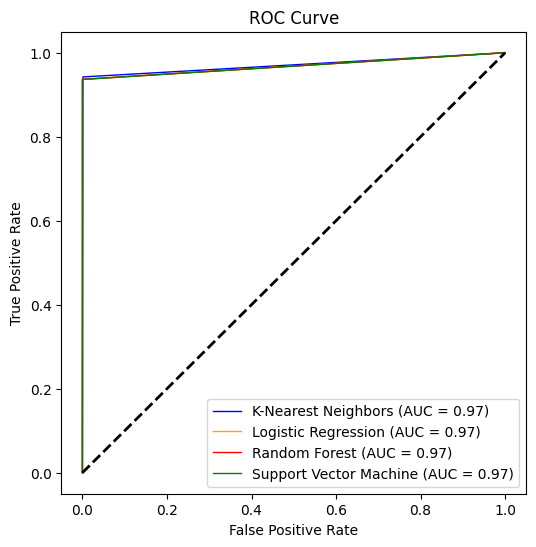

In [ ]:
models=[
    {'label': 'K-Nearest Neighbors',
     'model': KNeighborsClassifier(n_neighbors=3,weights='uniform',metric='euclidean')},
    {'label': 'Logistic Regression',
     'model': LogisticRegression(class_weight='balanced',penalty='l2',solver='lbfgs')},
    {'label': 'Random Forest',
     'model': RandomForestClassifier(max_depth=10,max_features='auto',min_samples_split=2,
                                     n_estimators=150,criterion='gini')},
    {'label': 'Support Vector Machine',
     'model': SVC(C=1, class_weight='balanced')}
]


results_test = []
tprs = []
aucs = []
_, X_test_imp=impute_missing_x_test(X_train, X_test, numerical_columns)
fig, ax = plt.subplots(figsize=(6, 6))


colors = ['blue', 'orange', 'red', 'green']

for num, pair in enumerate(models):

  print(pair['label'])
  model=pair['model']

  y_pred_train,y_pred_test,pipeline=test_model(model,X_train,y_train,X_test,y_test,numerical_columns,
                                               cat_index_list,num_index_list,ord_index_list)

  # Calculate evaluation metrics and scores for the test and training sets
  conf_matrix_test, class_report_test, auc_test = get_scores(y_pred_test, y_test)

  # Print scores and evaluation metrics for the test set
  print('======== Test Set ==========')
  print_scores(conf_matrix_test, class_report_test, auc_test)

  results_test.append(pd.DataFrame(class_report_test))

  fpr, tpr, thresholds = roc_curve(y_pred_test,y_test)

  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, color=colors[num], lw=1, label=(f"{pair['label']} (AUC = %0.2f)" % roc_auc))

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False  Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Each DF is a result for each model - KNN, LR, RF, SVM

results_test_df = pd.DataFrame()

for data in results_test:
  results_test_df=pd.concat([results_test_df,data],axis=0)

In [ ]:
results_test_df

0            1  accuracy     macro avg  weighted avg
precision      0.995678     0.982463  0.994791      0.989070      0.994753
recall         0.998734     0.942377  0.994791      0.970555      0.994791
f1-score       0.997204     0.962002  0.994791      0.979603      0.994741
support    37137.000000  2794.000000  0.994791  39931.000000  39931.000000
precision      0.995114     0.998881  0.995367      0.996997      0.995384
recall         0.999919     0.936341  0.995367      0.968130      0.995367
f1-score       0.997511     0.966600  0.995367      0.982056      0.995298
support    37072.000000  2859.000000  0.995367  39931.000000  39931.000000
precision      0.995141     0.998881  0.995392      0.997011      0.995409
recall         0.999919     0.936669  0.995392      0.968294      0.995392
f1-score       0.997524     0.966775  0.995392      0.982150      0.995324
support    37073.000000  2858.000000  0.995392  39931.000000  39931.000000
precision      0.995114     0.998507  0.995342      0.996811      0.995357
recall         0.999892     0.936319  0.995342      0.968106      0.995342
f1-score       0.997497     0.966414  0.995342      0.981956      0.995273
support    37073.000000  2858.000000  0.995342  39931.000000  39931.000000

# Feature importances

[Pipeline] . (step 1 of 2) Processing columntransformer, total=   1.1s
[Pipeline]  (step 2 of 2) Processing randomforestclassifier, total=  16.3s
Elapsed time to compute the importances: 105.373 seconds


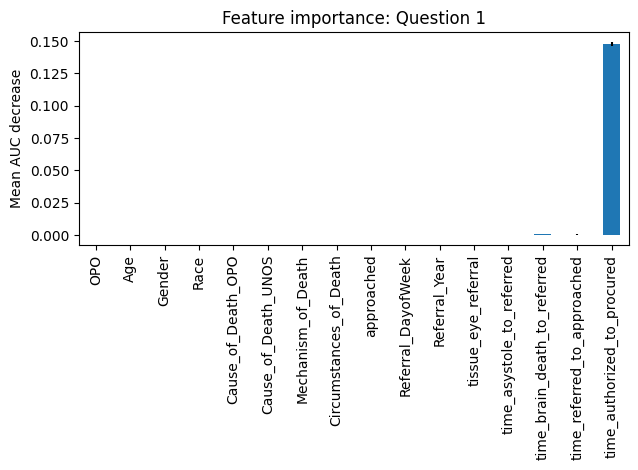

In [ ]:
forest_importances=feature_importance(X, X_train,y_train,X_test,y_test,numerical_columns,
                                      cat_index_list,num_index_list,ord_index_list,'Question 1')

In [ ]:
pd.DataFrame(forest_importances,columns=['mean AUC loss'])

mean AUC loss
OPO                               -0.000051
Age                                0.000384
Gender                             0.000023
Race                              -0.000039
Cause_of_Death_OPO                -0.000030
Cause_of_Death_UNOS                0.000016
Mechanism_of_Death                -0.000023
Circumstances_of_Death             0.000017
approached                         0.000045
Referral_DayofWeek                -0.000042
Referral_Year                     -0.000028
tissue_eye_referral               -0.000021
time_asystole_to_referred          0.000185
time_brain_death_to_referred       0.000684
time_referred_to_approached        0.000373
time_authorized_to_procured        0.147905

## Part 2: Research Question 2 (Prediction of multiple transplantations)

In [ ]:
df_new2.head()

OPO   Age Gender                      Race  brain_death  \
0  OPO1  62.0      M         White / Caucasian        False   
1  OPO1  14.0      F         White / Caucasian        False   
2  OPO1  55.0      M         White / Caucasian        False   
3  OPO1  48.0      F  Black / African American        False   
4  OPO1  80.0      F         White / Caucasian        False   

  Cause_of_Death_OPO     Cause_of_Death_UNOS Mechanism_of_Death  \
0                NaN  Injury_External Causes                NaN   
1                NaN                     NaN                NaN   
2                NaN         Nervous Disease    Nervous Disease   
3                NaN     Respiratory Disease     Cardiovascular   
4                NaN                     NaN                NaN   

  Circumstances_of_Death  approached  ...  outcome_lung_left  \
0                    NaN       False  ...                NaN   
1                    NaN       False  ...                NaN   
2                  Other        True  ...                NaN   
3                  Other       False  ...                NaN   
4                    NaN       False  ...                NaN   

   outcome_lung_right  outcome_intestine outcome_pancreas tissue_eye_referral  \
0                 NaN                NaN              NaN                True   
1                 NaN                NaN              NaN                True   
2                 NaN                NaN              NaN                True   
3                 NaN                NaN              NaN                True   
4                 NaN                NaN              NaN                True   

  time_asystole_to_referred time_brain_death_to_referred  \
0     Milestone not reached        Milestone not reached   
1             Over 24 hours        Milestone not reached   
2     Milestone not reached        Milestone not reached   
3           Within 24 hours        Milestone not reached   
4           Within 24 hours        Milestone not reached   

  time_referred_to_approached time_approached_to_authorized  \
0       Milestone not reached         Milestone not reached   
1       Milestone not reached         Milestone not reached   
2       Milestone not reached         Milestone not reached   
3       Milestone not reached         Milestone not reached   
4       Milestone not reached         Milestone not reached   

  time_authorized_to_procured  
0       Milestone not reached  
1       Milestone not reached  
2       Milestone not reached  
3       Milestone not reached  
4       Milestone not reached  

[5 rows x 36 columns]

In [ ]:
# Get subset of transplanted donors only
print('Subset of: ' + str(df_new2[df_new2['transplanted']==True].shape[0]) + ' records') #Subset of 8972 records
df_new2=df_new2[df_new2['transplanted']==True].reset_index().drop('index',axis=1)

#Dropping this variable since it is the inclusion criterion for this Question
df_new2=df_new2.drop(['transplanted'],axis=1)

df_new2.head()

Subset of: 8972 records


OPO   Age Gender                      Race  brain_death  \
0  OPO1  25.0      M                  Hispanic         True   
1  OPO1  25.0      M  Black / African American         True   
2  OPO1  61.0      M                  Hispanic         True   
3  OPO1  55.0      M         White / Caucasian         True   
4  OPO1  44.0      F  Black / African American         True   

       Cause_of_Death_OPO     Cause_of_Death_UNOS      Mechanism_of_Death  \
0                     NaN     Respiratory Disease  Injury_External Causes   
1                     NaN  Injury_External Causes  Injury_External Causes   
2  Injury_External Causes                   Other  Injury_External Causes   
3                     NaN     Respiratory Disease                   Other   
4                     NaN     Respiratory Disease          Cardiovascular   

  Circumstances_of_Death  approached  ...  outcome_lung_left  \
0     Non-motor Accident        True  ...       Transplanted   
1               Homicide       False  ...                NaN   
2                Suicide        True  ...       Transplanted   
3                  Other        True  ...       Transplanted   
4                  Other        True  ...                NaN   

   outcome_lung_right outcome_intestine  \
0        Transplanted               NaN   
1        Transplanted               NaN   
2        Transplanted               NaN   
3        Transplanted               NaN   
4                 NaN               NaN   

                                outcome_pancreas tissue_eye_referral  \
0  Recovered for Transplant but not Transplanted                True   
1                                   Transplanted                True   
2                                            NaN                True   
3                                            NaN                True   
4                         Recovered for Research                True   

  time_asystole_to_referred time_brain_death_to_referred  \
0     Milestone not reached                Over 24 hours   
1     Milestone not reached              Within 24 hours   
2     Milestone not reached                Over 24 hours   
3     Milestone not reached                Over 24 hours   
4     Milestone not reached                Over 24 hours   

  time_referred_to_approached time_approached_to_authorized  \
0               Over 24 hours               Within 24 hours   
1       Milestone not reached         Milestone not reached   
2               Over 24 hours               Within 24 hours   
3               Over 24 hours               Within 24 hours   
4               Over 24 hours               Within 24 hours   

   time_authorized_to_procured  
0                Over 24 hours  
1                Over 24 hours  
2                Over 24 hours  
3                Over 24 hours  
4                Over 24 hours  

[5 rows x 35 columns]

In [ ]:
df_new2.isna().sum()

OPO                                 0
Age                                 0
Gender                              0
Race                                0
brain_death                         0
Cause_of_Death_OPO               8052
Cause_of_Death_UNOS                 0
Mechanism_of_Death                  0
Circumstances_of_Death              0
approached                          0
authorized                          0
procured                            0
time_asystole                    5985
time_brain_death                 1598
time_referred                       0
time_approached                   120
time_authorized                     6
time_procured                       1
Referral_DayofWeek                  0
Referral_Year                       0
Procured_Year                       1
outcome_heart                    5334
outcome_liver                    1284
outcome_kidney_left               659
outcome_kidney_right              653
outcome_lung_left                5653
outcome_lung

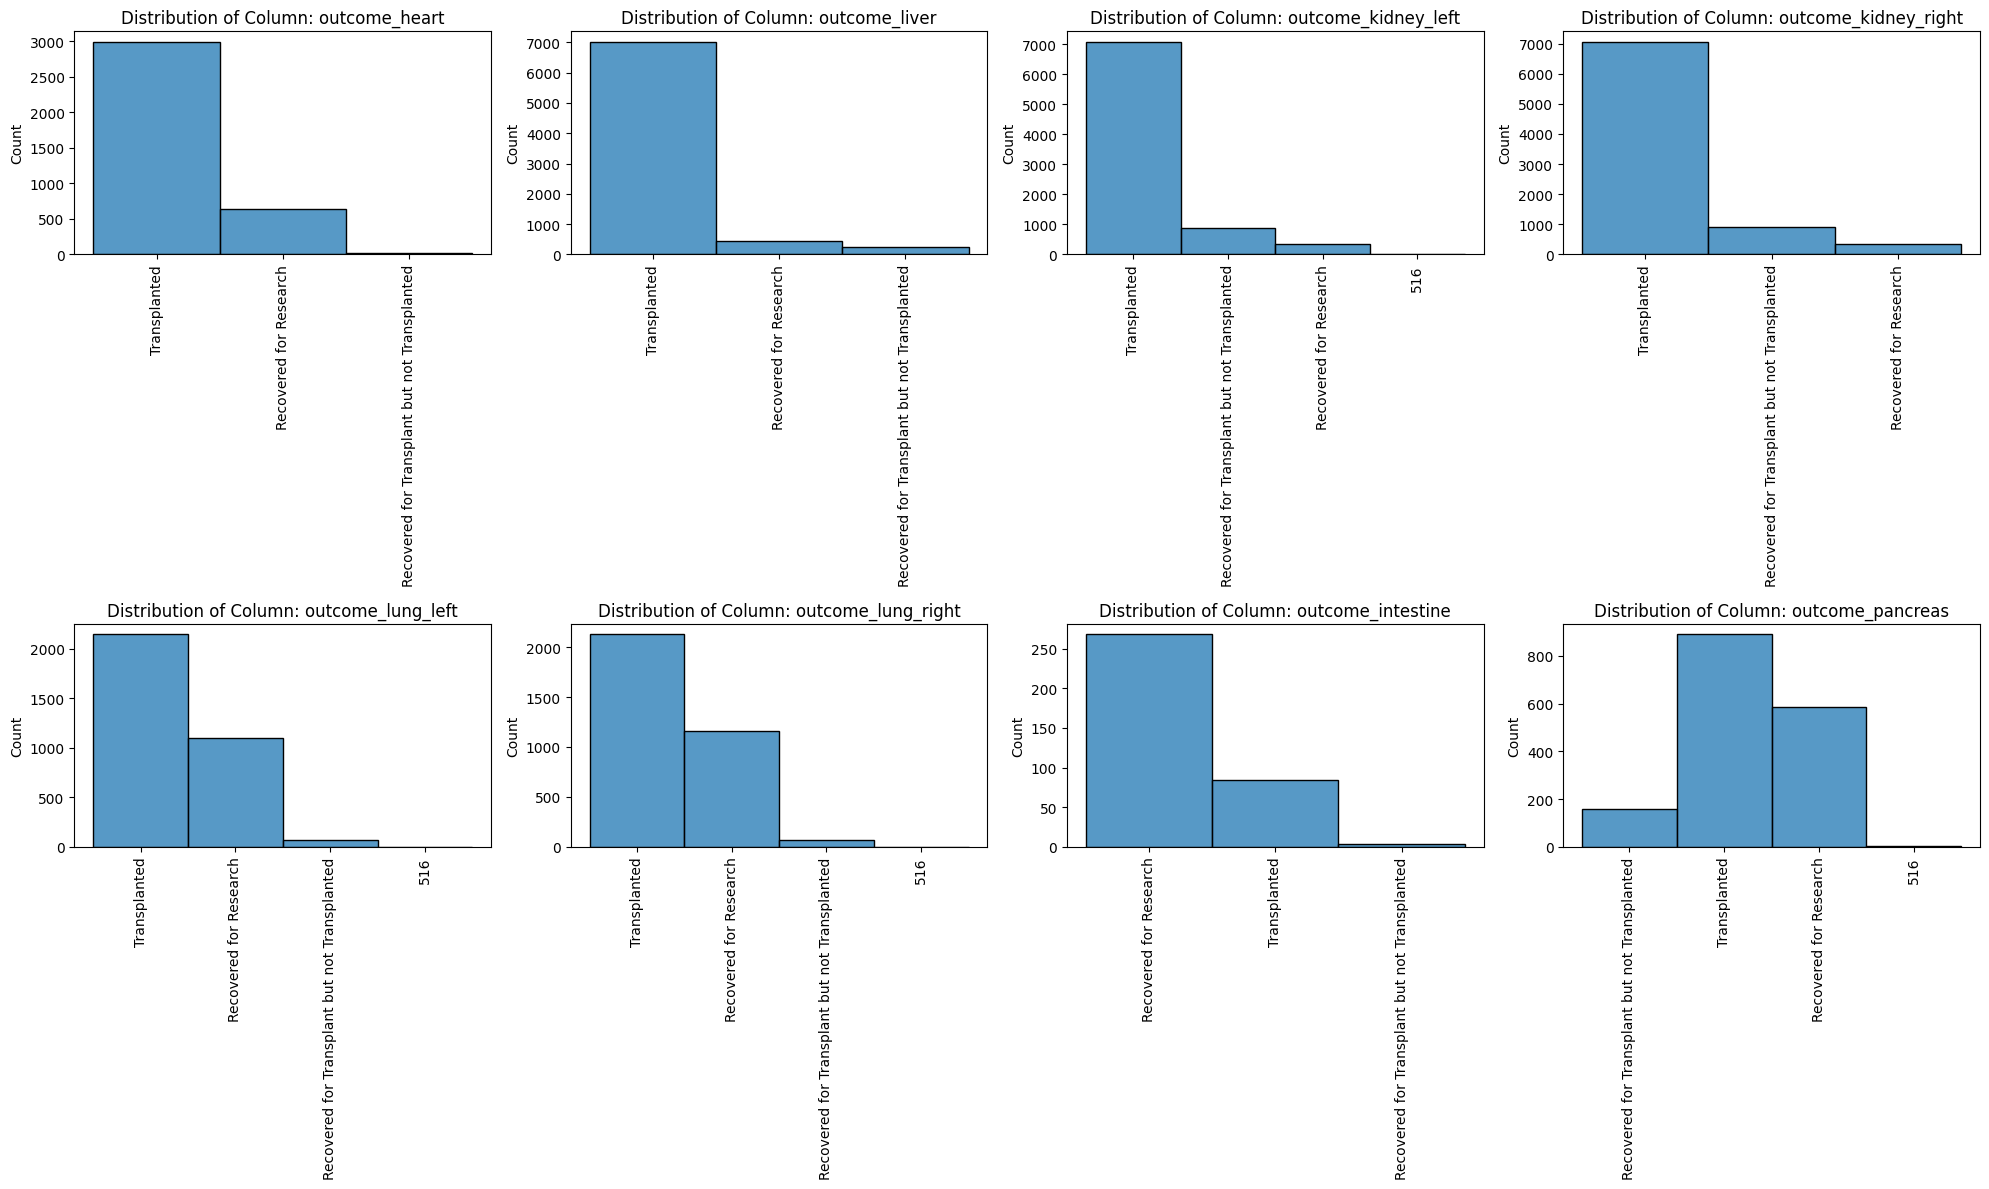

In [ ]:
#Visualize data distributions

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 12), sharex=False, sharey=False)
axes = axes.ravel()
cols = df_new2.columns[-8:]

for col, ax in zip(cols, axes):
    sns.histplot(data=df_new2, x=col, fill=True, ax=ax)
    ax.tick_params(axis='x', rotation=90)
    ax.set(title=f'Distribution of Column: {col}', xlabel=None)

fig.tight_layout()
plt.show()

#516 value in lung left and right columns - no interpretation available, likely data entry error

# Feature engineering
Make a copy of dataframe before feature engineering

In [ ]:
df_new2_v2 = df_new2.copy()

In [ ]:
# Run in case something gets messed up
#df_new2=df_new2_v2

# Replace "missing values" with new category: not recovered or transplanted

In [ ]:
outcome_vars=['outcome_heart', 'outcome_liver',
              'outcome_kidney_left', 'outcome_kidney_right',
              'outcome_lung_left', 'outcome_lung_right',
              'outcome_intestine', 'outcome_pancreas']

for col in outcome_vars:
  df_new2[col].replace({np.nan:'Not Recovered or Transplanted'},inplace=True)

# Create new variables

In [ ]:
def count_transplants(row):
  """
  Counts number of Transplanted organs in a column.

  Parameters
  ----------
  row (DataFrame): a row inside Pandas dataframe.

  Returns
  -------
  count (int): Number of transplants per row.
  """

  count=0
  for col in df.columns[-8:]:
    if row[col] == 'Transplanted':
      count+=1
  return count

count    8972.000000
mean        3.274744
std         1.663665
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         8.000000
Name: num_transplants, dtype: float64


<Axes: xlabel='num_transplants', ylabel='Count'>

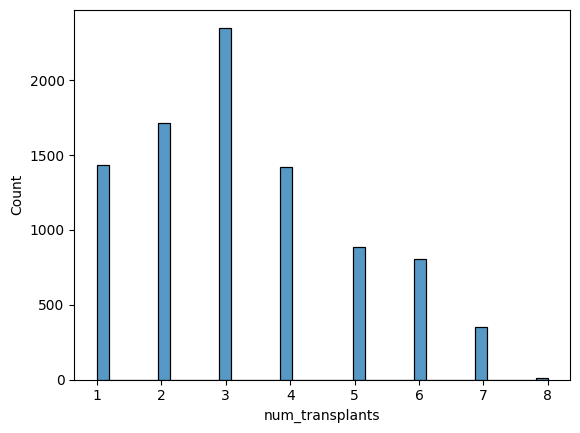

In [ ]:
# New column with number of transplants
df_new2['num_transplants']=df_new2.apply(count_transplants,axis=1)

print((df_new2['num_transplants']).describe())
sns.histplot(data=df_new2, x='num_transplants', fill=True)

In [ ]:
df_new2['multiple_transplants']=np.where(df_new2['num_transplants']>=4,1,0) #1 = at least half of organs donated, 0 = less than half
df_new2.head()

OPO   Age Gender                      Race  brain_death  \
0  OPO1  25.0      M                  Hispanic         True   
1  OPO1  25.0      M  Black / African American         True   
2  OPO1  61.0      M                  Hispanic         True   
3  OPO1  55.0      M         White / Caucasian         True   
4  OPO1  44.0      F  Black / African American         True   

       Cause_of_Death_OPO     Cause_of_Death_UNOS      Mechanism_of_Death  \
0                     NaN     Respiratory Disease  Injury_External Causes   
1                     NaN  Injury_External Causes  Injury_External Causes   
2  Injury_External Causes                   Other  Injury_External Causes   
3                     NaN     Respiratory Disease                   Other   
4                     NaN     Respiratory Disease          Cardiovascular   

  Circumstances_of_Death  approached  ...              outcome_intestine  \
0     Non-motor Accident        True  ...  Not Recovered or Transplanted   
1               Homicide       False  ...  Not Recovered or Transplanted   
2                Suicide        True  ...  Not Recovered or Transplanted   
3                  Other        True  ...  Not Recovered or Transplanted   
4                  Other        True  ...  Not Recovered or Transplanted   

                                outcome_pancreas tissue_eye_referral  \
0  Recovered for Transplant but not Transplanted                True   
1                                   Transplanted                True   
2                  Not Recovered or Transplanted                True   
3                  Not Recovered or Transplanted                True   
4                         Recovered for Research                True   

  time_asystole_to_referred time_brain_death_to_referred  \
0     Milestone not reached                Over 24 hours   
1     Milestone not reached              Within 24 hours   
2     Milestone not reached                Over 24 hours   
3     Milestone not reached                Over 24 hours   
4     Milestone not reached                Over 24 hours   

  time_referred_to_approached time_approached_to_authorized  \
0               Over 24 hours               Within 24 hours   
1       Milestone not reached         Milestone not reached   
2               Over 24 hours               Within 24 hours   
3               Over 24 hours               Within 24 hours   
4               Over 24 hours               Within 24 hours   

  time_authorized_to_procured num_transplants  multiple_transplants  
0               Over 24 hours               6                     1  
1               Over 24 hours               6                     1  
2               Over 24 hours               5                     1  
3               Over 24 hours               3                     0  
4               Over 24 hours               1                     0  

[5 rows x 37 columns]

In [ ]:
print(df_new2['multiple_transplants'].value_counts())

0    5503
1    3469
Name: multiple_transplants, dtype: int64


In [ ]:
# % of less than 4 transplants class
df_new2['multiple_transplants'].value_counts()[0]/len(df_new2['multiple_transplants'])

0.6133526526972805

In [ ]:
# % of at least 4 transplants class
df_new2['multiple_transplants'].value_counts()[1]/len(df_new2['multiple_transplants'])

0.38664734730271955

# Correlations with additional vars / further feature engineering

<Axes: >

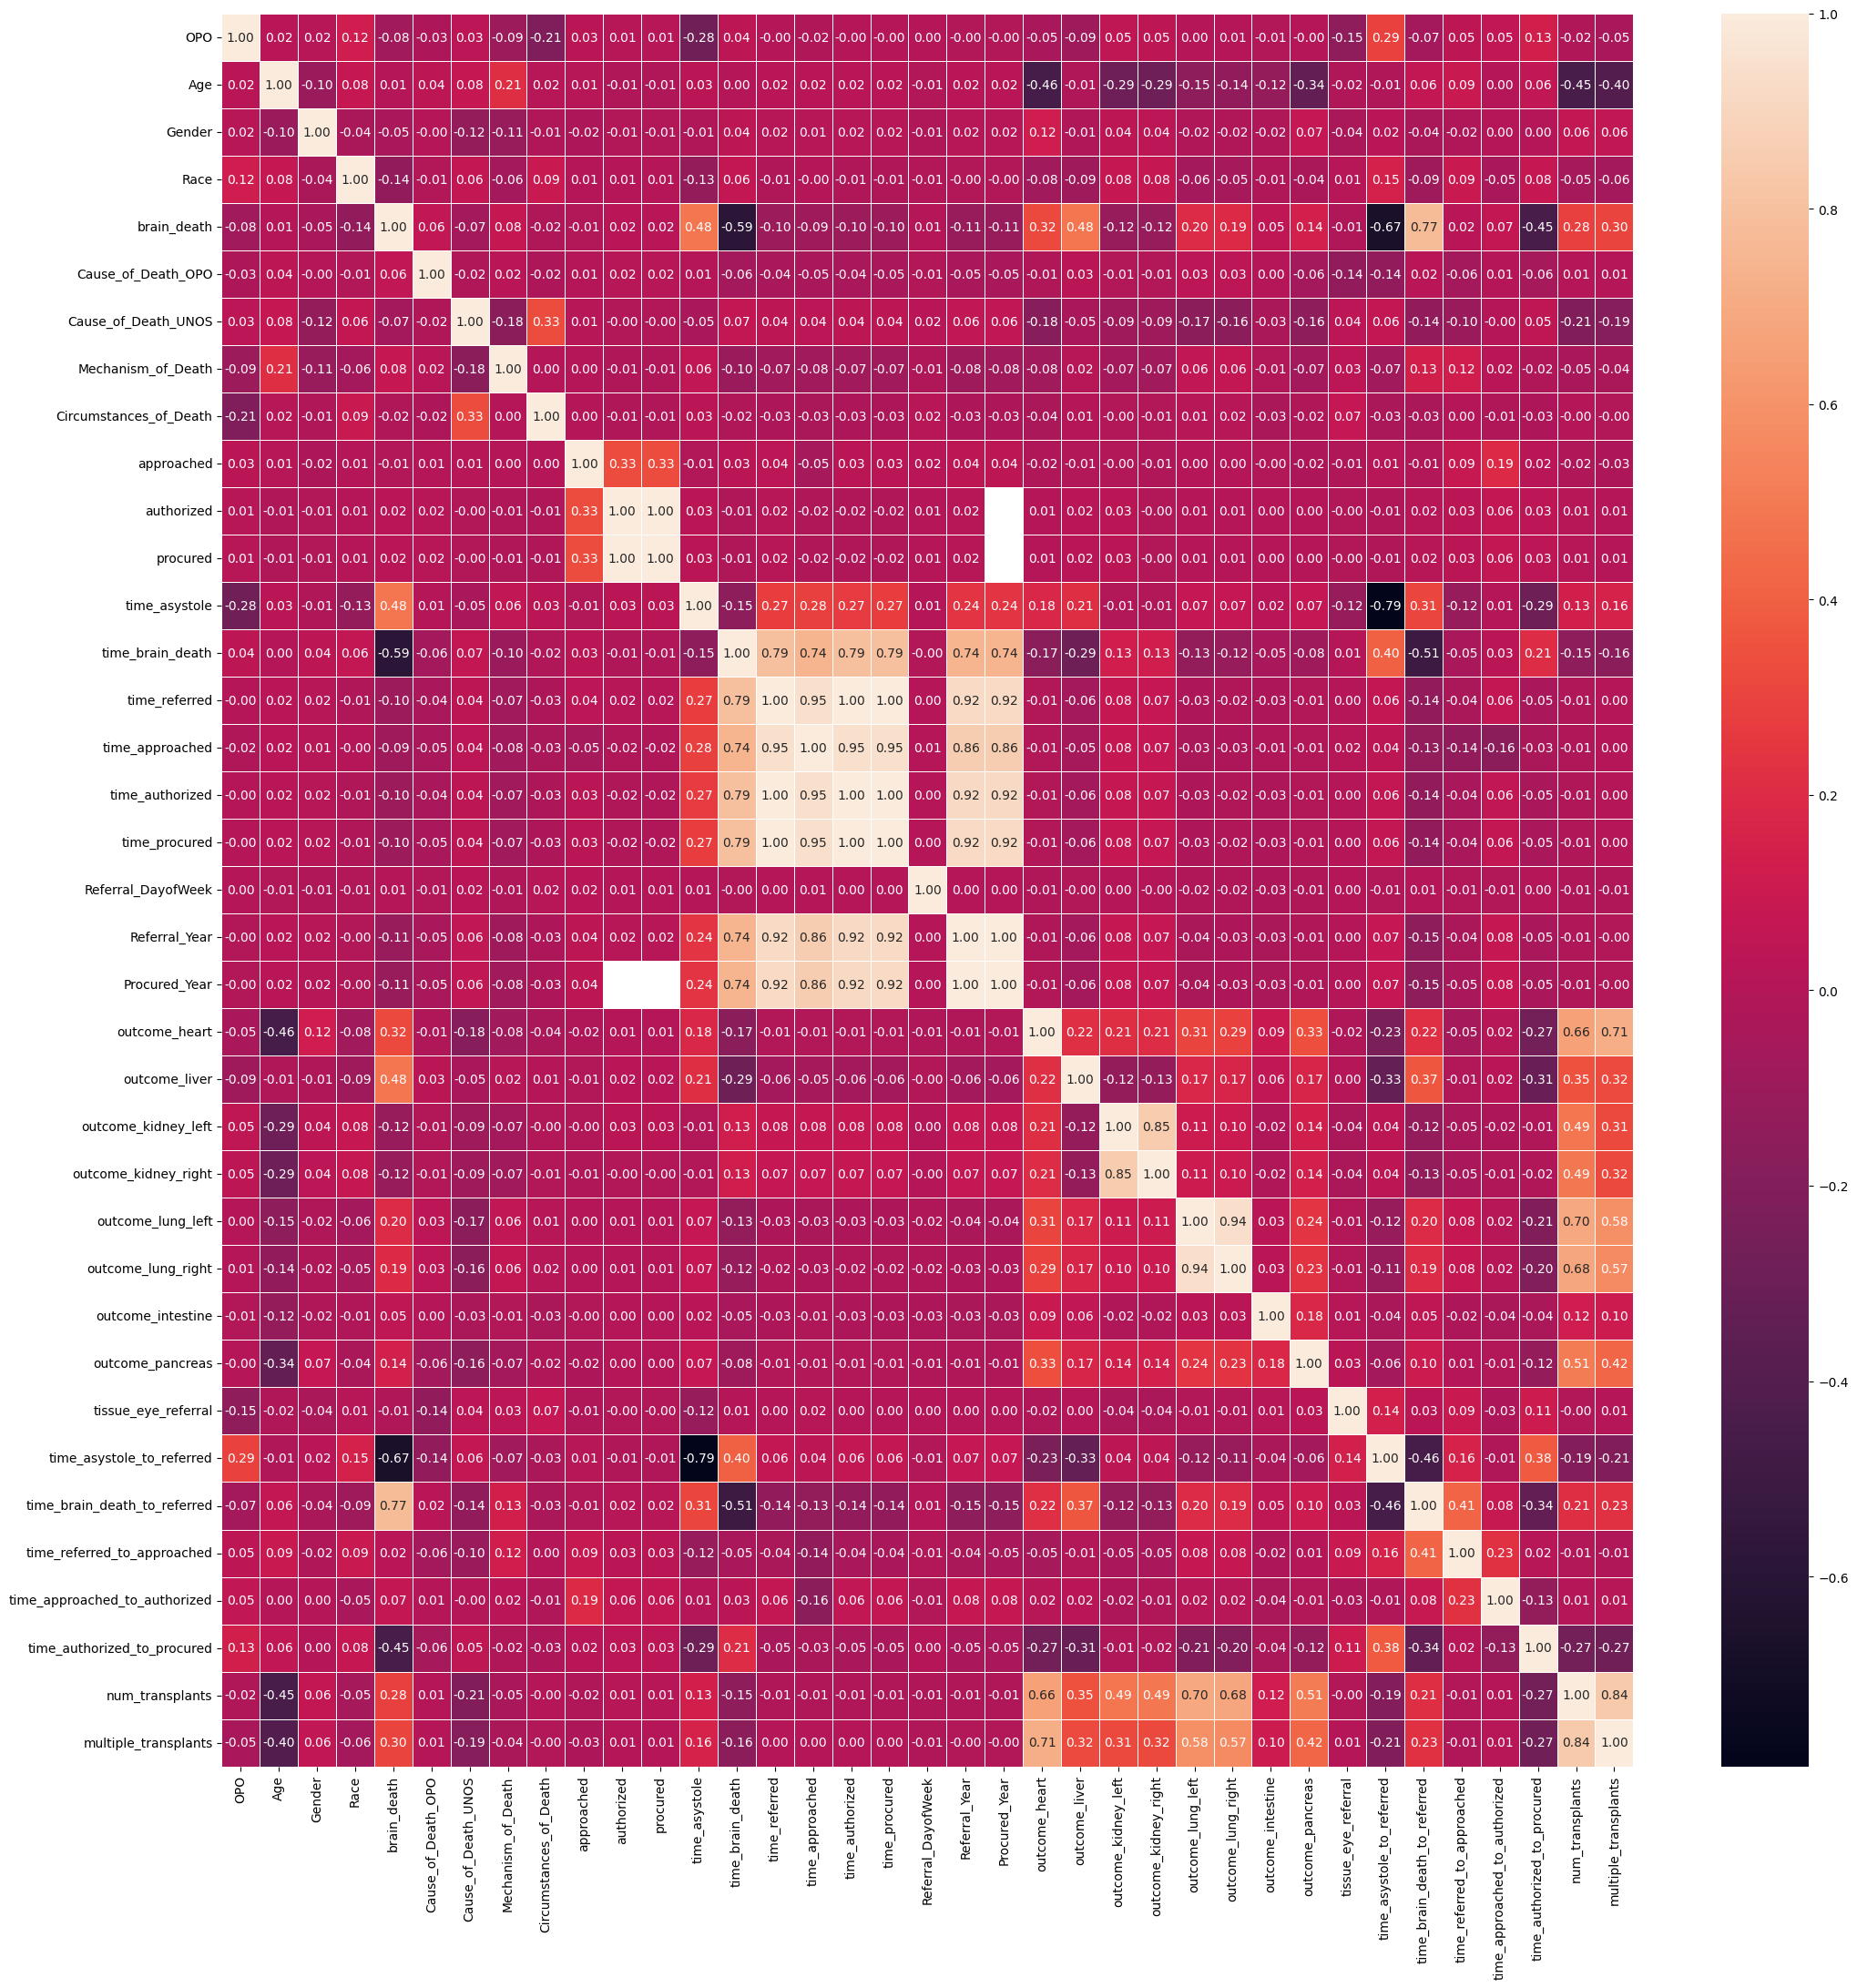

In [ ]:
df_test=df_new2.copy()

# Select only the object columns
object_columns = df_test.select_dtypes(include=['object']).columns

# Apply label encoding to each object column
label_encoder = LabelEncoder()
for column in object_columns:
    df_test[column] = label_encoder.fit_transform(df_test[column])

# Convert the entire DataFrame to float
df_test_copy = df_test.astype(float)

fig, ax = plt.subplots(figsize=(25,25))         # Sample figsize in inches
corr_matrix3 = df_test_copy.corr()
sns.heatmap(corr_matrix3, annot=True, fmt=".2f",linewidths=.5, ax=ax)

Deal with multicollinearity within outcome variables

In [ ]:
# Combine kidney and lung lateralities because they are highly collinear
# Shows that either one of them were donated (at least a kidney)
df_new2['outcome_kidney'] = df_new2.apply(lambda x: (x['outcome_kidney_left'] or x['outcome_kidney_right']), axis=1)
df_new2['outcome_lung'] = df_new2.apply(lambda x: (x['outcome_lung_left'] or x['outcome_lung_right']), axis=1)

# Drop the individual features
df_new2 = df_new2.drop(['outcome_kidney_left', 'outcome_kidney_right',
                        'outcome_lung_left', 'outcome_lung_right'],axis=1)

df_new2.columns


Index(['OPO', 'Age', 'Gender', 'Race', 'brain_death', 'Cause_of_Death_OPO',
       'Cause_of_Death_UNOS', 'Mechanism_of_Death', 'Circumstances_of_Death',
       'approached', 'authorized', 'procured', 'time_asystole',
       'time_brain_death', 'time_referred', 'time_approached',
       'time_authorized', 'time_procured', 'Referral_DayofWeek',
       'Referral_Year', 'Procured_Year', 'outcome_heart', 'outcome_liver',
       'outcome_intestine', 'outcome_pancreas', 'tissue_eye_referral',
       'time_asystole_to_referred', 'time_brain_death_to_referred',
       'time_referred_to_approached', 'time_approached_to_authorized',
       'time_authorized_to_procured', 'num_transplants',
       'multiple_transplants', 'outcome_kidney', 'outcome_lung'],
      dtype='object')

In [ ]:
#Move transplanted column to end
df_new2.insert(len(df_new2.columns)-11, 'outcome_kidney', df_new2.pop('outcome_kidney'))
df_new2.insert(len(df_new2.columns)-11, 'outcome_lung', df_new2.pop('outcome_lung'))

df_new2.columns

Index(['OPO', 'Age', 'Gender', 'Race', 'brain_death', 'Cause_of_Death_OPO',
       'Cause_of_Death_UNOS', 'Mechanism_of_Death', 'Circumstances_of_Death',
       'approached', 'authorized', 'procured', 'time_asystole',
       'time_brain_death', 'time_referred', 'time_approached',
       'time_authorized', 'time_procured', 'Referral_DayofWeek',
       'Referral_Year', 'Procured_Year', 'outcome_heart', 'outcome_liver',
       'outcome_intestine', 'outcome_lung', 'outcome_kidney',
       'outcome_pancreas', 'tissue_eye_referral', 'time_asystole_to_referred',
       'time_brain_death_to_referred', 'time_referred_to_approached',
       'time_approached_to_authorized', 'time_authorized_to_procured',
       'num_transplants', 'multiple_transplants'],
      dtype='object')

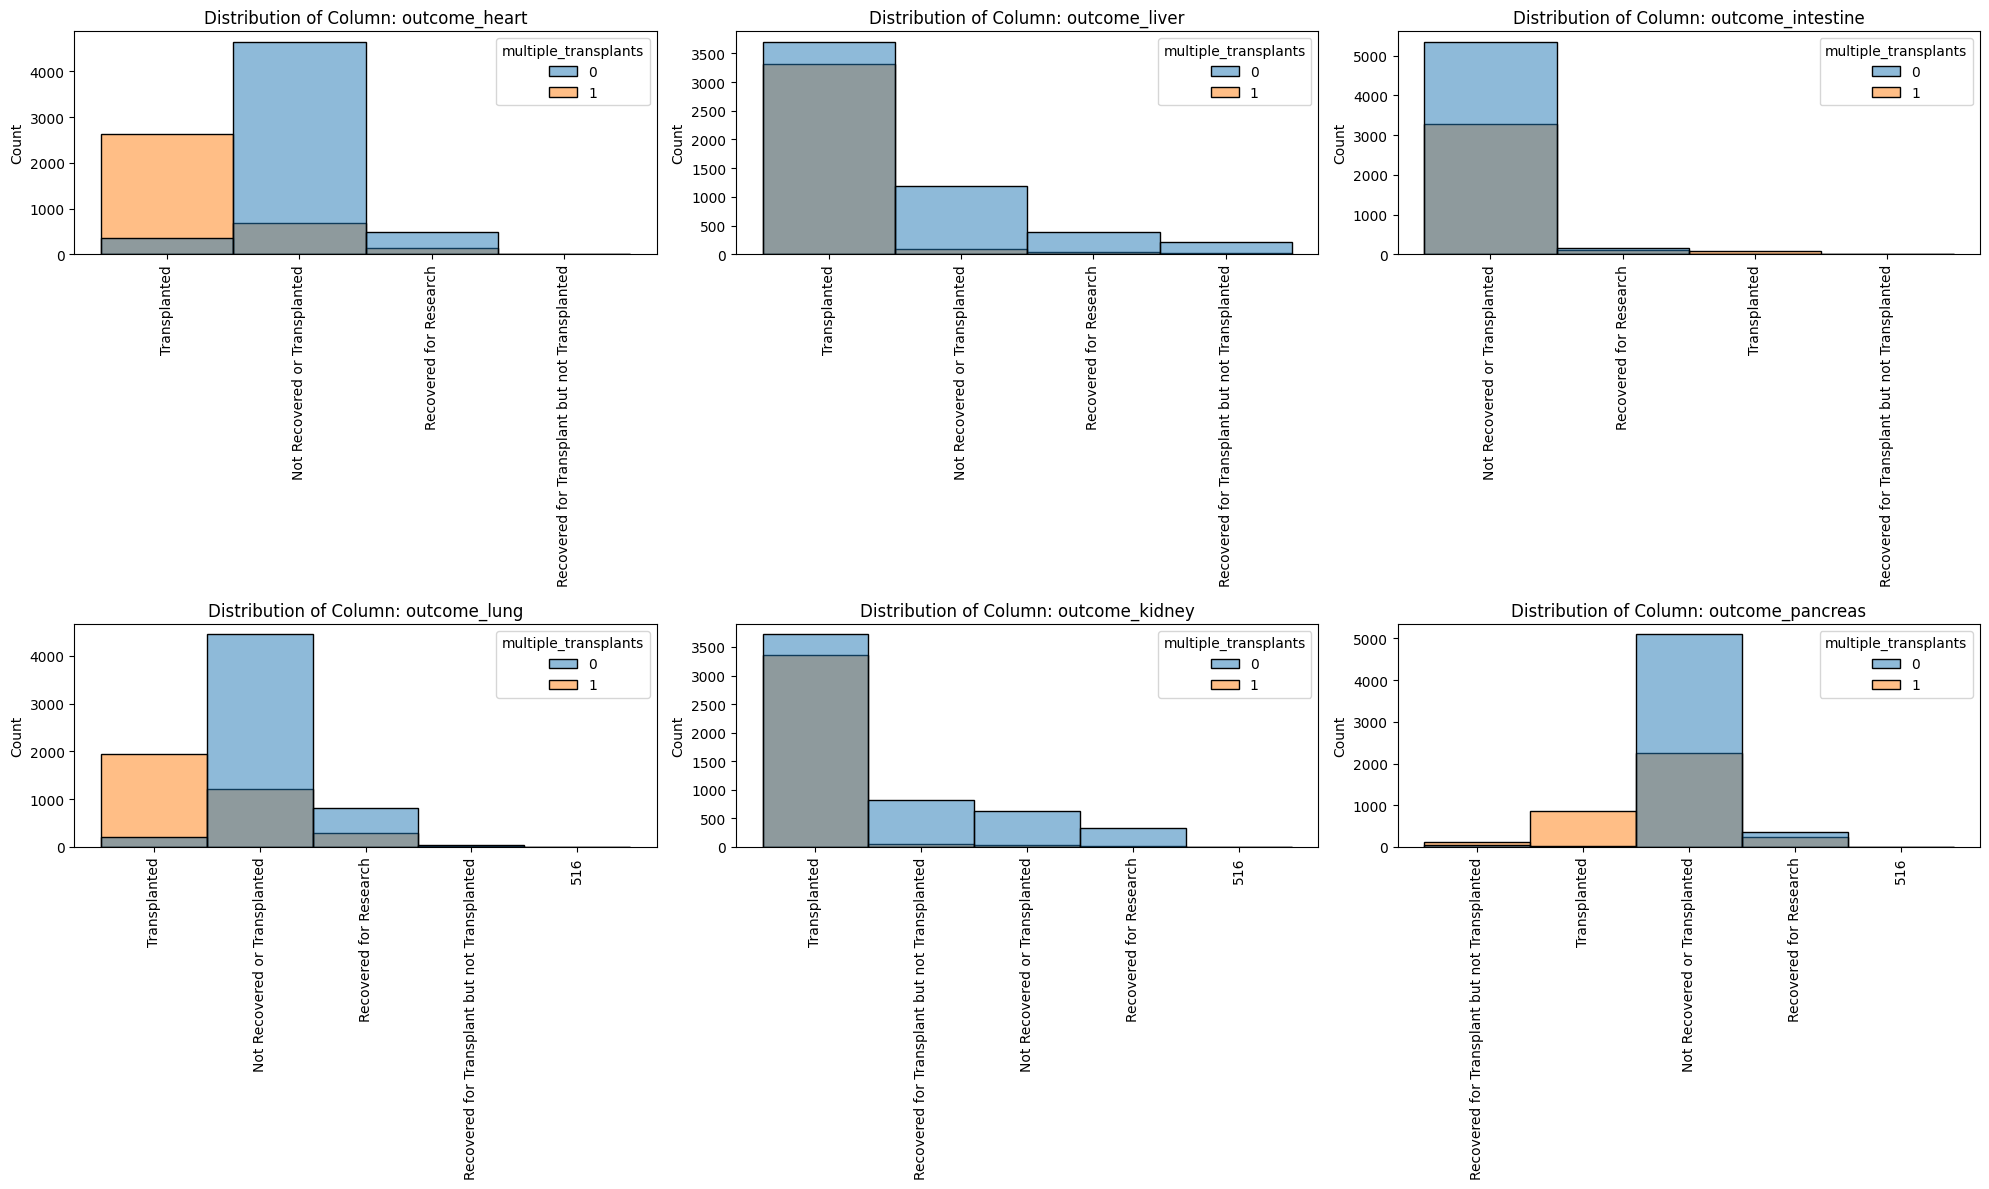

In [ ]:
#Visualize data distributions

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 12), sharex=False, sharey=False)
axes = axes.ravel()
cols = df_new2.columns[-14:-8]

for col, ax in zip(cols, axes):
    sns.histplot(data=df_new2, x=col, fill=True, ax=ax, hue='multiple_transplants')
    ax.tick_params(axis='x', rotation=90)
    ax.set(title=f'Distribution of Column: {col}', xlabel=None)

fig.tight_layout()
plt.show()

#516 value in lung left and right columns - no interpretation available, likely data entry error

<Axes: >

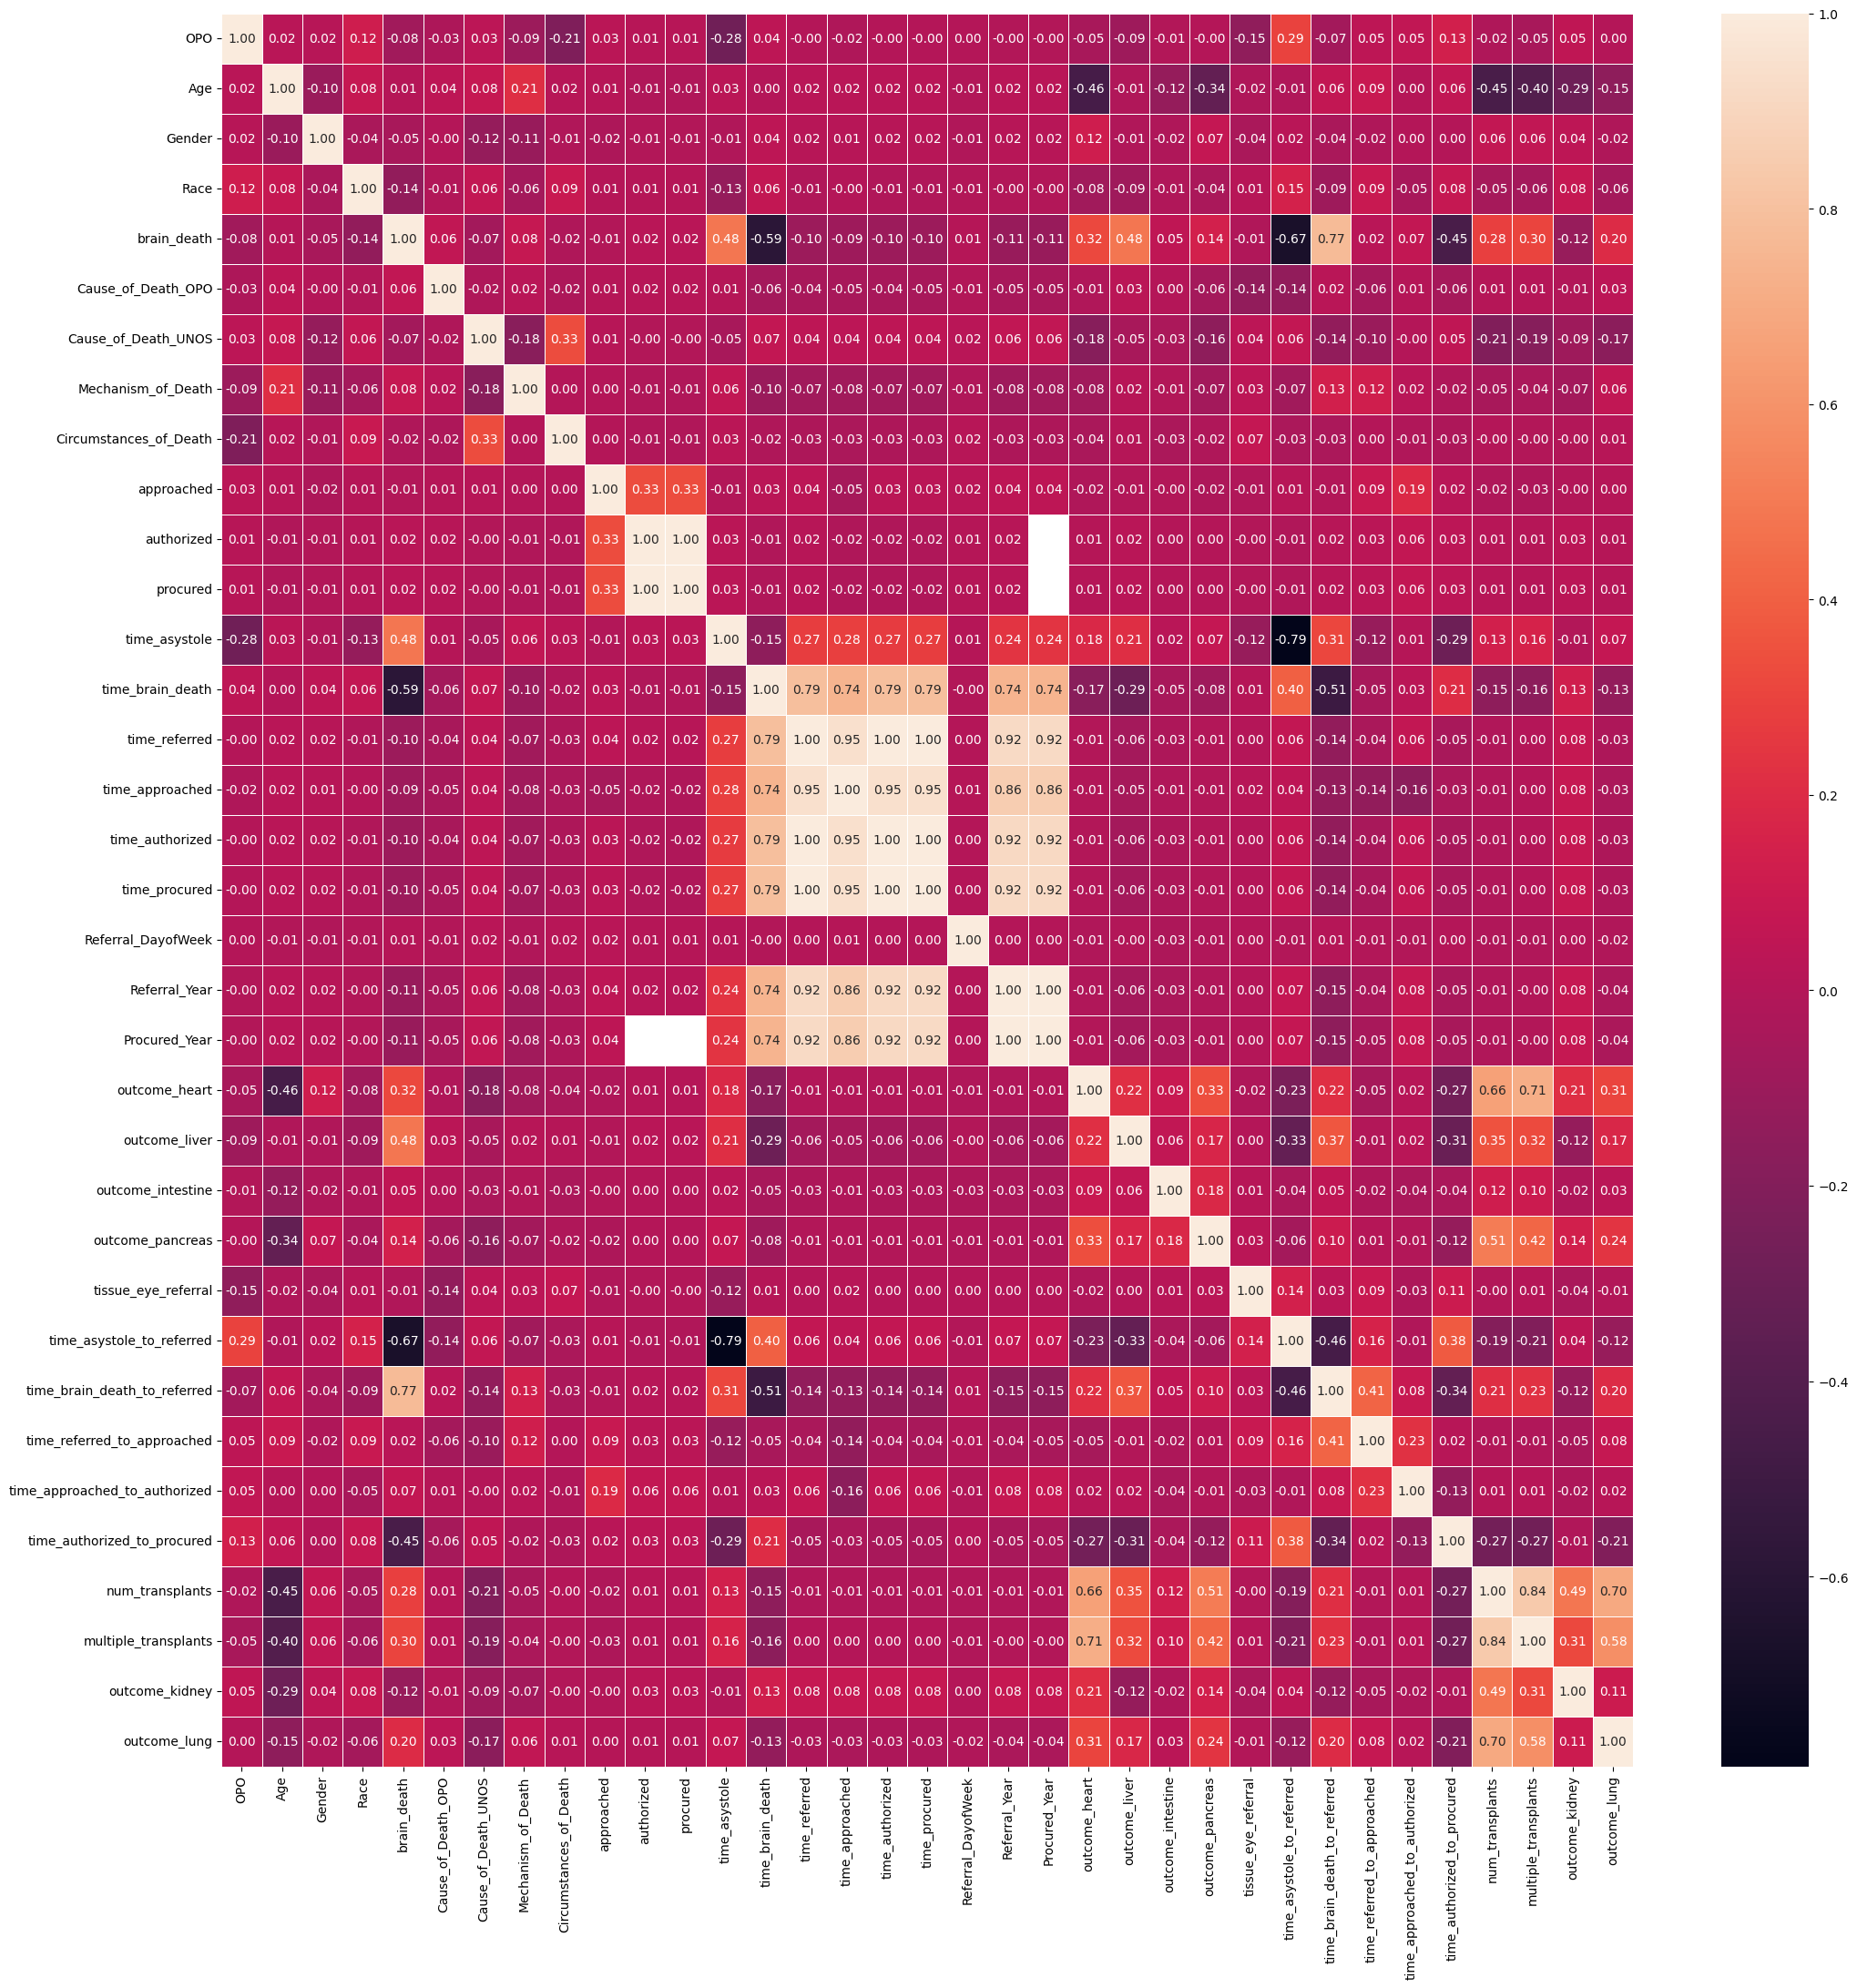

In [ ]:
df_test=df_new2.copy()

# Select only the object columns
object_columns = df_test.select_dtypes(include=['object']).columns

# Apply label encoding to each object column
label_encoder = LabelEncoder()
for column in object_columns:
    df_test[column] = label_encoder.fit_transform(df_test[column])

# Convert the entire DataFrame to float
df_test_copy = df_test.astype(float)

fig, ax = plt.subplots(figsize=(25,25))         # Sample figsize in inches
corr_matrix3 = df_test_copy.corr()
sns.heatmap(corr_matrix3, annot=True, fmt=".2f",linewidths=.5, ax=ax)

# Dropping other features

In [ ]:
cols_large_missing[:5]

['time_brain_death',
 'time_approached',
 'time_authorized',
 'time_procured',
 'Procured_Year']

In [ ]:
# Drop time variables and keep (some of) the time interval variables
df_new2 = df_new2.drop(cols_large_missing[:5],axis=1) # drop Procured_Year as it is almost perfectly collinear with Referral_Year (0.98)

In [ ]:
# Drop collinear / MNAR variables (num_transplants is dropped because it was only created to make the multiple_transplants column)
cols_collinear2 = ['time_referred','time_asystole','brain_death','procured','num_transplants']
df_new2 = df_new2.drop(cols_collinear2,axis=1)
len(df_new2.columns)

25

In [ ]:
df_new2.columns

Index(['OPO', 'Age', 'Gender', 'Race', 'Cause_of_Death_OPO',
       'Cause_of_Death_UNOS', 'Mechanism_of_Death', 'Circumstances_of_Death',
       'approached', 'authorized', 'Referral_DayofWeek', 'Referral_Year',
       'outcome_heart', 'outcome_liver', 'outcome_intestine', 'outcome_lung',
       'outcome_kidney', 'outcome_pancreas', 'tissue_eye_referral',
       'time_asystole_to_referred', 'time_brain_death_to_referred',
       'time_referred_to_approached', 'time_approached_to_authorized',
       'time_authorized_to_procured', 'multiple_transplants'],
      dtype='object')

# CV stage - Part 2

In [ ]:
# Preprocess and transform input data
X2 = df_new2.drop('multiple_transplants', axis=1).to_numpy()

# Extract the target variable
y2 = df_new2['multiple_transplants'].to_numpy()

# Split the data into training and testing sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=1)

In [ ]:
categorical_columns2=get_categorical_cols(df_new2)
numerical_columns2=get_numerical_cols(df_new2)
ordinal_columns2=get_ordinal_cols(df_new2)

cat_index_list2,num_index_list2,ord_index_list2=get_list_indices(df_new2.drop('multiple_transplants', axis=1),
                                                                 categorical_columns2,numerical_columns2,ordinal_columns2)




In [ ]:
# Models for hyperparameter search
knn = KNeighborsClassifier()
param_grid_knn = {
    'kneighborsclassifier__n_neighbors': [3,4],
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__metric': ['euclidean', 'manhattan']
}

lr = LogisticRegression()
a=0.61 # proportion of majority class
param_grid_lr = {
    'logisticregression__C': [1,2],
    'logisticregression__class_weight': [None, 'balanced', {0: 1-a, 1: a}],
    'logisticregression__penalty': ['l2', 'l1'],
    'logisticregression__solver' : ['lbfgs', 'liblinear']}

rf = RandomForestClassifier()
param_grid_rf = {
    'randomforestclassifier__n_estimators': [100,150], #50
    'randomforestclassifier__max_features': ['auto','sqrt'],#'log2'
    'randomforestclassifier__max_depth': [10,20],
    'randomforestclassifier__min_samples_split': [2,5],
    #'min_samples_leaf': [1,2,4],
    'randomforestclassifier__criterion' :['gini', 'entropy']#'log_loss'
    }

svc = SVC()
param_grid_svc = {
    'svc__C': [1,2],
    'svc__class_weight': [None, 'balanced'],
    #'svc__kernel': ['linear', 'poly', 'rbf'],
    #'svc__gamma' :['scale','auto'],
}

In [ ]:
print('Cross-Validation KNN results on raw unbalanced data')
knn_raw_model2=run_pipeline(X_train2,y_train2,cat_index_list2,num_index_list2,ord_index_list2,
                           knn,param_grid_knn)
knn_raw_model2

Cross-Validation KNN results on raw unbalanced data
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.1s
[Pipeline]  (step 2 of 2) Processing kneighborsclassifier, total=   0.0s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.0s
[Pipeline]  (step 2 of 2) Processing kneighborsclassifier, total=   0.0s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.0s
[Pipeline]  (step 2 of 2) Processing kneighborsclassifier, total=   0.0s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.1s
[Pipeline]  (step 2 of 2) Processing kneighborsclassifier, total=   0.0s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.1s
[Pipeline]  (step 2 of 2) Processing kneighborsclassifier, total=   0.0s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.1s
[Pipeline]  (step 2 of 2) Processing kneighborsclassifier, total=   0.0s
[Pipeline] . (step 1 of 

Mean
fit_time         19.907627
score_time        1.571896
test_recall0      0.929542
test_recall1      0.884973
test_precision0   0.928340
test_precision1   0.886815
test_f1-score0    0.928941
test_f1-score1    0.885892
test_roc_auc      0.907258

In [ ]:
print('Cross-Validation LR results on raw unbalanced data')
lr_raw_model2=run_pipeline(X_train2,y_train2,cat_index_list2,num_index_list2,ord_index_list2,
                           lr,param_grid_lr)
lr_raw_model2

Cross-Validation LR results on raw unbalanced data
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.1s
[Pipeline]  (step 2 of 2) Processing logisticregression, total=   0.2s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.1s
[Pipeline]  (step 2 of 2) Processing logisticregression, total=   0.1s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.1s
[Pipeline]  (step 2 of 2) Processing logisticregression, total=   0.1s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.1s
[Pipeline]  (step 2 of 2) Processing logisticregression, total=   0.1s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.1s
[Pipeline]  (step 2 of 2) Processing logisticregression, total=   0.2s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.1s
[Pipeline]  (step 2 of 2) Processing logisticregression, total=   0.0s
[Pipeline] . (step 1 of 2) Processi

Mean
fit_time         53.421456
score_time        0.022836
test_recall0      0.989219
test_recall1      0.982747
test_precision0   0.989224
test_precision1   0.982755
test_f1-score0    0.989220
test_f1-score1    0.982746
test_roc_auc      0.985983

In [ ]:
print('Cross-Validation RF results on raw unbalanced data - test and validation')
rf_raw_model2=run_pipeline(X_train2,y_train2,cat_index_list2,num_index_list2,ord_index_list2,
                          rf,param_grid_rf)
rf_raw_model2

Cross-Validation RF results on raw unbalanced data - test and validation
Fitting 5 folds for each of 32 candidates, totalling 160 fits
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.1s
[Pipeline]  (step 2 of 2) Processing randomforestclassifier, total=   0.4s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.1s
[Pipeline]  (step 2 of 2) Processing randomforestclassifier, total=   0.4s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.0s
[Pipeline]  (step 2 of 2) Processing randomforestclassifier, total=   0.8s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.0s
[Pipeline]  (step 2 of 2) Processing randomforestclassifier, total=   0.4s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.0s
[Pipeline]  (step 2 of 2) Processing randomforestclassifier, total=   0.9s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.1s
[Pipeline]  (step 2 of 2) Processing randomforestclassifier, tot

Mean
fit_time         194.309647
score_time         0.051962
test_recall0       0.987719
test_recall1       0.981354
test_precision0    0.988377
test_precision1    0.980356
test_f1-score0     0.988040
test_f1-score1     0.980833
test_roc_auc       0.984536

In [ ]:
print('Cross-Validation SVM results on raw unbalanced data')
svc_raw_model2=run_pipeline(X_train2,y_train2,cat_index_list2,num_index_list2,ord_index_list2,
                          svc,param_grid_svc)
svc_raw_model2

Cross-Validation SVM results on raw unbalanced data
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.1s
[Pipeline] ............... (step 2 of 2) Processing svc, total=   1.5s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.1s
[Pipeline] ............... (step 2 of 2) Processing svc, total=   0.9s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.1s
[Pipeline] ............... (step 2 of 2) Processing svc, total=   1.3s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.1s
[Pipeline] ............... (step 2 of 2) Processing svc, total=   1.1s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.1s
[Pipeline] ............... (step 2 of 2) Processing svc, total=   1.1s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.1s
[Pipeline] ............... (step 2 of 2) Processing svc, total=   1.6s
[Pipeline] . (step 1 of 2) Processin

Mean
fit_time         26.459465
score_time        0.115418
test_recall0      0.956016
test_recall1      0.877847
test_precision0   0.926065
test_precision1   0.925764
test_f1-score0    0.940802
test_f1-score1    0.901169
test_roc_auc      0.916931

# Test on held-out test set

In [ ]:
# Preprocess and transform input data
X2 = df_new2.drop('multiple_transplants', axis=1)#.to_numpy()

# Extract the target variable
y2 = df_new2['multiple_transplants']#.to_numpy()

# Split the data into training and testing sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=1)

K-Nearest Neighbors
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.1s
[Pipeline]  (step 2 of 2) Processing kneighborsclassifier, total=   0.0s
======== Test Set ==========
AUC :  0.92080163150051
Confusion Matrix:
[[1539  108]
 [  97  948]]

Classification Report:
{'0': {'precision': 0.9407090464547677, 'recall': 0.9344262295081968, 'f1-score': 0.9375571123971976, 'support': 1647}, '1': {'precision': 0.8977272727272727, 'recall': 0.907177033492823, 'f1-score': 0.9024274155164207, 'support': 1045}, 'accuracy': 0.923848439821694, 'macro avg': {'precision': 0.9192181595910203, 'recall': 0.9208016315005099, 'f1-score': 0.9199922639568092, 'support': 2692}, 'weighted avg': {'precision': 0.9240240711407884, 'recall': 0.923848439821694, 'f1-score': 0.9239202129765395, 'support': 2692}}
Logistic Regression
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.1s
[Pipeline]  (step 2 of 2) Processing logisticregression, total=   0.2s
======== Test Set =========

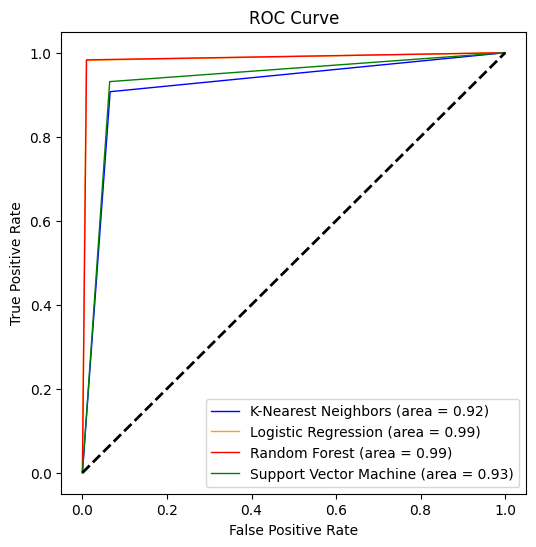

In [ ]:
models2=[
    {'label': 'K-Nearest Neighbors',
     'model': KNeighborsClassifier(metric='euclidean',n_neighbors=3,weights='uniform')},
    {'label': 'Logistic Regression',
     'model': LogisticRegression(C=1,class_weight=None,penalty='l2')},
    {'label': 'Random Forest',
     'model': RandomForestClassifier(criterion='gini',max_depth=10,max_features='auto',
                                     min_samples_split=2,n_estimators=100)},
    {'label': 'Support Vector Machine',
     'model': SVC(C=1,class_weight=None)}
]

results_test2 = []
tprs = []
aucs = []
_, X_test2_imp=impute_missing_x_test(X_train2, X_test2, numerical_columns2)
fig, ax = plt.subplots(figsize=(6, 6))

colors = ['blue', 'orange', 'red', 'green']

for num, pair in enumerate(models2):

  print(pair['label'])
  model=pair['model']

  y_pred_train2,y_pred_test2,pipeline=test_model(model,X_train2,y_train2,X_test2,y_test2,numerical_columns2,
                                               cat_index_list2,num_index_list2,ord_index_list2)

  # Calculate evaluation metrics and scores for the test and training sets
  conf_matrix_test, class_report_test, auc_test = get_scores(y_pred_test2, y_test2)

  # Print scores and evaluation metrics for the test set
  print('======== Test Set ==========')
  print_scores(conf_matrix_test, class_report_test, auc_test)

  results_test2.append(pd.DataFrame(class_report_test))

  fpr, tpr, thresholds = metrics.roc_curve(y_pred_test2,y_test2)

  roc_auc = metrics.auc(fpr, tpr)
  plt.plot(fpr, tpr, color=colors[num], lw=1, label=(f"{pair['label']} (area = %0.2f)" % roc_auc))

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Each DF is a result for each model - KNN, LR, RF, SVM

results_test_df2 = pd.DataFrame()

for data in results_test2:
  results_test_df2=pd.concat([results_test_df2,data],axis=0)

In [ ]:
results_test_df2

0            1  accuracy    macro avg  weighted avg
precision     0.940709     0.897727  0.923848     0.919218      0.924024
recall        0.934426     0.907177  0.923848     0.920802      0.923848
f1-score      0.937557     0.902427  0.923848     0.919992      0.923920
support    1647.000000  1045.000000  0.923848  2692.000000   2692.000000
precision     0.988386     0.985795  0.987370     0.987091      0.987366
recall        0.990809     0.982075  0.987370     0.986442      0.987370
f1-score      0.989596     0.983932  0.987370     0.986764      0.987366
support    1632.000000  1060.000000  0.987370  2692.000000   2692.000000
precision     0.988998     0.984848  0.987370     0.986923      0.987367
recall        0.990208     0.982987  0.987370     0.986597      0.987370
f1-score      0.989602     0.983917  0.987370     0.986760      0.987368
support    1634.000000  1058.000000  0.987370  2692.000000   2692.000000
precision     0.957213     0.897727  0.933878     0.927470      0.934718
recall        0.935484     0.931238  0.933878     0.933361      0.933878
f1-score      0.946224     0.914176  0.933878     0.930200      0.934104
support    1674.000000  1018.000000  0.933878  2692.000000   2692.000000

# Feature importances

[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.1s
[Pipeline]  (step 2 of 2) Processing randomforestclassifier, total=   1.9s
Elapsed time to compute the importances: 24.129 seconds


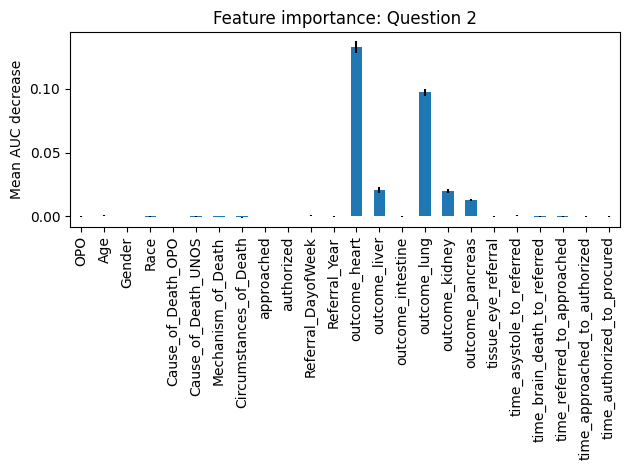

In [ ]:
forest_importances2=feature_importance(X2,X_train2,y_train2,X_test2,y_test2,numerical_columns2,
                                       cat_index_list2,num_index_list2,ord_index_list2,'Question 2')

In [ ]:
pd.DataFrame(forest_importances2,columns=['mean AUC loss'])

mean AUC loss
OPO                                -0.000035
Age                                 0.000503
Gender                              0.000376
Race                               -0.000251
Cause_of_Death_OPO                 -0.000008
Cause_of_Death_UNOS                -0.000372
Mechanism_of_Death                 -0.000446
Circumstances_of_Death             -0.000849
approached                          0.000000
authorized                          0.000000
Referral_DayofWeek                  0.000442
Referral_Year                       0.000063
outcome_heart                       0.132585
outcome_liver                       0.020768
outcome_intestine                   0.000007
outcome_lung                        0.097300
outcome_kidney                      0.019887
outcome_pancreas                    0.013080
tissue_eye_referral                 0.000039
time_asystole_to_referred           0.000613
time_brain_death_to_referred       -0.000310
time_referred_to_approached        -0.000306
time_approached_to_authorized      -0.000032
time_authorized_to_procured         0.000034